# 초기 설정 (마운트, 경로설정, 라이브러리 임포트)

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Colab Notebooks/column_shap

/content/drive/MyDrive/Colab Notebooks/column_shap


In [3]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import statistics
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import f_oneway
from sklearn.datasets import fetch_openml
from scipy.stats import ks_2samp
from scipy.stats import f_oneway
from sklearn.model_selection import GridSearchCV
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_regression
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from scipy.stats.mstats import winsorize
import itertools
import matplotlib.patches as patches
import matplotlib.patches as mpatches

In [5]:
!pip install tqdm  # tqdm 라이브러리 설치
from tqdm import tqdm  # tqdm 임포트

# 1차 함수 선언

## train/test split

In [6]:
def train_test_index(X_tmp,y_tmp,num):
  same_check=[0]
  while 0 in same_check:
    count=-1
    df_index_test=pd.DataFrame(columns=range(num))
    df_index_train=pd.DataFrame(columns=range(num))
    for ii in range(num):
      count_false_X=100
      count_false_y=100
      while  count_false_y>0:
        X_train, X_test, y_train, y_test = train_test_split(X_tmp,y_tmp,test_size=0.2,random_state=None,shuffle=True)
        mean_threshold_y=0.01*y_tmp.mean()
        std_threshold_y = 0.1 * y_tmp.std()
        a1=np.abs(y_tmp.mean()-y_train.mean())<mean_threshold_y
        a2=np.abs(y_tmp.mean()-y_test.mean())<mean_threshold_y
        a3=np.abs(y_tmp.std()-y_train.std())<std_threshold_y
        a4=np.abs(y_tmp.std()-y_test.std())<std_threshold_y
        data=a1,a2,a3,a4
        count_false_y=0
        for value in data:
          if value == False:
              count_false_y += 1
      df_index_test[ii]=sorted(X_test.index.tolist())
      df_index_train[ii]=sorted(X_train.index.tolist())
    # create dataframe with two empty columns
    dice = pd.DataFrame(columns=['col1', 'col2'])
    # loop through 10 natural numbers and randomly select two different numbers for each row
    for i in range(1, num+1):
        numbers = random.sample(range(0, num), 2)
        dice.loc[i-1] = numbers
    same_check=[]
    for i in range(num):
      same_check_tmp=np.sum(df_index_test[dice.iloc[i][0]]-df_index_test[dice.iloc[i][1]])
      same_check.append(same_check_tmp)
    count+=1
  return df_index_train, df_index_test


1개 train/test split data set 뽑기

In [7]:
def train_test_index2(X_tmp,y_tmp):
  df_index_test=pd.DataFrame(columns=range(1))
  df_index_train=pd.DataFrame(columns=range(1))
  count_false_X=100
  count_false_y=100
  while  count_false_y>0:
  # Load your dataset as a Pandas DataFrame
    X_train, X_test, y_train, y_test = train_test_split(X_tmp,y_tmp,test_size=0.2,random_state=None,shuffle=True)
    mean_threshold_y=0.1*y_tmp.mean()
    std_threshold_y = 0.1 * y_tmp.std()
    a1=np.abs(y_tmp.mean()-y_train.mean())<mean_threshold_y
    a2=np.abs(y_tmp.mean()-y_test.mean())<mean_threshold_y
    a3=np.abs(y_tmp.std()-y_train.std())<std_threshold_y
    a4=np.abs(y_tmp.std()-y_test.std())<std_threshold_y
    data=a1,a2,a3,a4
    count_false_y=0
    for value in data:
      if value == False:
          count_false_y += 1
  df_index_test=sorted(X_test.index.tolist())
  df_index_train=sorted(X_train.index.tolist())
  return df_index_train, df_index_test

## 중간 평가

In [8]:
def model_initial2(target_num,num2,model):
  X,y=data_input(target_num)
  num2=num2
  r2_test=0
  r2_train_result=[]
  r2_test_result=[]
  df_index_train,df_index_test=train_test_index(X,y,num2)

  for i in range(num2):
    X_train=X.loc[df_index_train[i]]
    y_train=y.loc[df_index_train[i]]
    X_test=X.loc[df_index_test[i]]
    y_test=y.loc[df_index_test[i]]

    model.fit(X_train, y_train)
    # Predict on the test set
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Compute the R-squared for the test set
    r2_train = r2_score(y_train,y_train_pred)
    r2_test = r2_score(y_test,y_test_pred)

    r2_train_result.append(r2_train)
    r2_test_result.append(r2_test)
  return r2_test_result

In [9]:
def model_initial(target_num,num2,step1_best_params_,step2_best_params_):
  X,y=data_input(target_num)
  base_score_value=np.median(y)
  model = xgb.XGBRegressor(objective='reg:squarederror',
                        base_score=base_score_value,
                        **step1_best_params_,
                        **step2_best_params_)
  num2=num2
  r2_test=0
  r2_train_result=[]
  r2_test_result=[]
  df_index_train,df_index_test=train_test_index(X,y,num2)

  for i in range(num2):
    X_train=X.loc[df_index_train[i]]
    y_train=y.loc[df_index_train[i]]
    X_test=X.loc[df_index_test[i]]
    y_test=y.loc[df_index_test[i]]


    model.fit(X_train, y_train)
    # Predict on the test set
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Compute the R-squared for the test set
    r2_train = r2_score(y_train,y_train_pred)
    r2_test = r2_score(y_test,y_test_pred)

    r2_train_result.append(r2_train)
    r2_test_result.append(r2_test)
  return r2_test_result

In [10]:
def eval_mid(X_train, X_test, y_train, y_test,model):
    # X_train, X_test, y_train, y_test = train_test_split(X_tmp,y_tmp,test_size=0.2,random_state=None,shuffle=True)
    model.fit(X_train, y_train)
    # Predict on the test set
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    # Compute the R-squared for the test set
    r2_train = r2_score(y_train,y_train_pred)
    r2_test = r2_score(y_test,y_test_pred)
    return r2_test

# 2차 함수 선언

## 데이터베이스 입력+data preprocessing

In [11]:
def data_input(target_num):
  if target_num==7:
    df_tmp = pd.read_csv("df_275samples_1107.csv", encoding='cp949')
    df=df_tmp.dropna()
  else:
    df_tmp = pd.read_csv("df_275samples_1107.csv", encoding='cp949')
    df=df_tmp

  pt = PowerTransformer(method='yeo-johnson')
  minmax = MinMaxScaler()
  trans = pt.fit_transform(df)
  df_trans=pd.DataFrame(trans)
  df_trans[df_trans.columns]=minmax.fit_transform(df_trans[df_trans.columns])
  df_output=df_trans.iloc[:, -3:]
  df_input=df_trans.iloc[:,:-3]
  X = df_input
  y = df_output.iloc[:,target_num]
  return X,y

In [12]:
def data_input1(target_num):
  # if target_num==7:
  #   df_tmp = pd.read_csv("df_275samples_1107.csv", encoding='cp949')
  #   df=df_tmp.dropna()
  # else:
  #   df_tmp = pd.read_csv("df_275samples_1107.csv", encoding='cp949')
  #   df=df_tmp
  df= pd.read_csv("df_275samples_1030.csv", encoding='cp949')
  pt = PowerTransformer(method='yeo-johnson')
  minmax = MinMaxScaler()
  trans = pt.fit_transform(df)
  df_trans=pd.DataFrame(trans)
  df_trans[df_trans.columns]=minmax.fit_transform(df_trans[df_trans.columns])
  df_output=df_trans.iloc[:, -8:]
  df_input=df_trans.iloc[:,:-8]
  X = df_input
  y = df_output.iloc[:,target_num]
  return X,y

In [13]:
def data_input2(target_num):
  # df_tmp = pd.read_csv("./(0417)df_columns_parameters_corr.csv", encoding='cp949')
  # df=df_tmp.dropna(); # DS4 일때만
  if target_num==3 or target_num == 6:
    df_tmp = pd.read_csv("./(0417)df_columns_parameters_corr.csv", encoding='cp949')
    df=df_tmp.dropna(); # DS4 일때만
  else:
    df = pd.read_csv("./(0417)df_columns_parameters_corr.csv", encoding='cp949')  # 나머지

  pt = PowerTransformer(method='yeo-johnson')
  minmax = MinMaxScaler()
  trans = pt.fit_transform(df)
  df_trans=pd.DataFrame(trans)
  df_trans[df_trans.columns]=minmax.fit_transform(df_trans[df_trans.columns])
  df_output=df_trans.iloc[:, 20:27]
  df_input=df_trans.iloc[:,0:20]
  X = df_input
  y = df_output.iloc[:,target_num]
  # ["DS1", "DS2","DS3","DS4", "Vy","Vu","DS4/DS2"]
  return X,y

## 초기 파라미터 튜닝

In [14]:
def initial_tuning(X_tmp,y_tmp):
  base_score_value=np.mean(y_tmp)
  model = xgb.XGBRegressor(objective='reg:squarederror',
                          base_score=base_score_value)
  X_train, X_test, y_train, y_test = train_test_split(X_tmp,y_tmp, test_size=0.2, random_state=None,shuffle=True)
  param_grid = {
      'max_depth': [3,5,7],
      'min_child_weight': [0.05,0.075,0.1],
      'gamma': [0.001,0.005,0.01,0.015,0.02],
      'reg_alpha': [0.01,0.05,0.1],
      'reg_lambda': [0.01,0.05,0.1],
  }
  df_param_grid=pd.DataFrame(param_grid.items())

  param_step1 = {
      df_param_grid.iloc[0,0]: df_param_grid.iloc[0,1],
      df_param_grid.iloc[1,0]: df_param_grid.iloc[1,1],
  }

  grid_search_step1 = GridSearchCV(model, param_grid=param_step1, cv=10, n_jobs=-1,scoring='neg_mean_squared_error')
  grid_search_step1.fit(X_train, y_train)

  model_0 = xgb.XGBRegressor(objective='reg:squarederror',
                                base_score=base_score_value,
                                **grid_search_step1.best_params_)
  ## step 2
  param_step2 = {
      df_param_grid.iloc[2,0]: df_param_grid.iloc[2,1],
      df_param_grid.iloc[3,0]: df_param_grid.iloc[3,1],
      df_param_grid.iloc[4,0]: df_param_grid.iloc[4,1],
  }
  grid_search_step2 = GridSearchCV(model_0, param_grid=param_step2, cv=10, n_jobs=-1)
  grid_search_step2.fit(X_train, y_train)

  step1_best_params_=grid_search_step1.best_params_
  step2_best_params_=grid_search_step2.best_params_
  return step1_best_params_,step2_best_params_

In [15]:
def objective_func(particle,X_train, X_test, y_train, y_test):
    # Convert particle values to appropriate format
    learning_rate = particle[0]
    max_depth = int(particle[1])
    min_child_weight = particle[2]
    gamma=particle[3]
    reg_alpha=particle[4]
    reg_lambda=particle[5]
    base_score_value=np.median(y_train)
    # Create an XGBoost regression model with the specified hyperparameters
    model = XGBRegressor(objective='reg:squarederror',
                         base_score=base_score_value,
                         learning_rate=learning_rate,
                         max_depth=max_depth,
                         min_child_weight=min_child_weight,
                         gamma=gamma,
                         reg_alpha=reg_alpha,
                         reg_lambda=reg_lambda,
                         )
    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)

    # Calculate the R-squared score
    r2 = r2_score(y_test, y_pred)

    return -r2 # Negative sign to maximize the R-squared

In [16]:
def initial_tunning_pso(X_train, X_test, y_train, y_test):
  bounds = [(0.05, 0.2),  # Learning rate
                  (3, 7),       # Max depth
                  (0.05, 0.1),  # Min child weight
                  (0.001,0.02),  #gamma
                  (0.01,0.1), #reg_alpha
                  (0.01, 0.1)]    #reg_lambda

  # X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=None,shuffle=True)
  # Define the number of particles
  n_particles = 50
  # Initialize the best cost and best position
  best_cost = np.inf
  best_pos = None

  # Run the PSO algorithm
  for _ in range(1):
      # Generate random particles within the bounds
      particles = np.random.uniform(low=[b[0] for b in bounds], high=[b[1] for b in bounds], size=(n_particles, len(bounds)))
      # Evaluate the objective function for each particle
      costs = np.array([objective_func(p,X_train, X_test, y_train, y_test) for p in particles])

      # Update the best cost and best position
      best_index = np.argmin(costs)
      if costs[best_index] < best_cost:
          best_cost = costs[best_index]
          best_pos = particles[best_index]
  base_score_value=np.mean(y_train)
  model = XGBRegressor(objective='reg:squarederror',
                      base_score=base_score_value,
                      learning_rate=best_pos[0],
                      max_depth=int(best_pos[1]),
                      min_child_weight=best_pos[2],
                      gamma=best_pos[3],
                      reg_alpha=best_pos[4],
                      reg_lambda=best_pos[5],)
  return model

## 이상치제거

In [17]:
def outlier_eliminater(X,y,num,var1,var2,var3,model):
  threshold = (y.mean() * var1) ** 2
  X_rsod=X
  y_rsod=y
  num=5
  remove_ind=[]
  remove_df = pd.DataFrame(index=range(round(0.2*len(y_rsod))), columns=range(num))
  # step1_best_params_,step2_best_params_ = initial_tuning(X_rsod,y_rsod)
  for iii in range (num): # outlier list 만들어 낼 case 개수
    remove_list=[]
    while len(remove_list)<var2: # 빈도 파악할 outlier 개수
      min_score = 1000
      base_score_value=np.median(y_rsod)
      for i in range(1): # removing set의 필터링
        df_index_train,df_index_test=train_test_index2(X_rsod,y_rsod)
        X_train=X_rsod.loc[df_index_train]
        y_train=y_rsod.loc[df_index_train]
        X_test=X_rsod.loc[df_index_test]
        y_test=y_rsod.loc[df_index_test]
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        score = mean_squared_error(y_test, preds)**0.5
        if score < min_score:
          remove_train = X_test
          remove_test = preds
          min_score = score

      pred_value = remove_test.tolist()
      remove_set = remove_train.reset_index()["index"].to_list()
      real_value = []

      for ii in remove_set:
        real_value.append(y[ii])

      count = 0
      for p, r in zip(pred_value, real_value):
        temp = (p - r) ** 2
        if temp > threshold:
          remove_ind.append(remove_set[count])
        count += 1

      remove_list.extend(remove_ind)
      X_rsod=X.drop(remove_list,axis=0)
      y_rsod=y.drop(remove_list,axis=0)
      remove_ind=[]
      for a in range  (len(remove_list)):
        remove_df[iii][a]=remove_list[a]

  tmp=remove_df.values.flatten().tolist()
  ttmp=[x for x in tmp if not pd.isna(x)]
  counts = Counter(ttmp)
  # Get the 5 most common values and their counts
  top_5 = counts.most_common(round(var3*len(y)))  # 최종 제거할 outlier 개수
  real_remove_df=pd.DataFrame(top_5)[0]

  X_rsod=X.drop(real_remove_df,axis=0)
  y_rsod=y.drop(real_remove_df,axis=0)
  return X_rsod,y_rsod,real_remove_df

In [18]:
def model_rsod(target_num,num,num2,var1,var2,var3,model):
  X,y=data_input(target_num)
  X_rsod,y_rsod,real_remove_df =outlier_eliminater(X,y,num,var1,var2,var3,model) #이상치 제거
  base_score_value=np.median(y)
  num2=num2
  r2_test=0
  r2_train_result=[]
  r2_test_result=[]
  df_index_train,df_index_test=train_test_index(X_rsod,y_rsod,num2)

  for i in range(num2):
    X_train=X_rsod.loc[df_index_train[i]]
    y_train=y_rsod.loc[df_index_train[i]]
    X_test=X_rsod.loc[df_index_test[i]]
    y_test=y_rsod.loc[df_index_test[i]]


    model.fit(X_train, y_train)
    # Predict on the test set
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Compute the R-squared for the test set
    r2_train = r2_score(y_train,y_train_pred)
    r2_test = r2_score(y_test,y_test_pred)

    r2_train_result.append(r2_train)
    r2_test_result.append(r2_test)
  return r2_test_result,X_rsod,y_rsod

## 차원축소

In [19]:
# def fs1(X_rsod,y_rsod,num,model):
#   num=num
#   ranking_df = pd.DataFrame(index=range(X_rsod.shape[1]), columns=range(num))
#   base_score_value=np.mean(y_rsod)
#   df_index_train,df_index_test=train_test_index(X_rsod,y_rsod,num)
#   for i in range(num):
#     X_train=X_rsod.loc[df_index_train[i]]
#     y_train=y_rsod.loc[df_index_train[i]]
#     X_test=X_rsod.loc[df_index_test[i]]
#     y_test=y_rsod.loc[df_index_test[i]]
#     model_fs1 = model
#     model_fs1.fit(X_train, y_train)
#     importances = model_fs1.feature_importances_

#     # Print the feature importances in descending order
#     indices = importances.argsort()[::-1]
#     ranking_df[i]=indices

#   row_avg = ranking_df.mean(axis=1)
#   good_feature=row_avg[row_avg<np.mean(row_avg)+0.5].index
#   X_fs1=X_rsod.iloc[:, good_feature]
#   y_fs1=y_rsod
#   return X_fs1,y_fs1,model_fs1

In [20]:
def fs1(X_rsod,y_rsod,model,num):
  ranking_df = pd.DataFrame(index=range(X_rsod.shape[1]), columns=range(num))
  importance_df = pd.DataFrame(index=range(X_rsod.shape[1]), columns=range(num))
  base_score_value=np.mean(y_rsod)
  df_index_train,df_index_test=train_test_index(X_rsod,y_rsod,100)
  for i in range(num):
    X_train=X_rsod.loc[df_index_train[i]]
    y_train=y_rsod.loc[df_index_train[i]]
    X_test=X_rsod.loc[df_index_test[i]]
    y_test=y_rsod.loc[df_index_test[i]]
    model_fs1 = model
    model_fs1.fit(X_train, y_train)
    importances = model_fs1.feature_importances_
    importance_df[i]=importances

    # Print the feature importances in descending order
    indices = importances.argsort()[::-1]
    ranking_df[i]=indices

  importance_df.mean(axis=1)
  iqr_low=[]
  for low in range(len(importance_df)):
      q1 = importance_df.iloc[low,:].quantile(0.25)
      q3 = importance_df.iloc[low,:].quantile(0.75)

      # IQR 계산
      iqr = q3 - q1
      iqr_low.append(iqr)
  x_tmp=importance_df.mean(axis=1)
  y_tmp=iqr_low
  x1=np.median(x_tmp)
  y1=np.median(y_tmp)

  importance_df.mean(axis=1)
  iqr_low=[]
  for low in range(len(importance_df)):
      q1 = importance_df.iloc[low,:].quantile(0.25)
      q3 = importance_df.iloc[low,:].quantile(0.75)

      # IQR 계산
      iqr = q3 - q1
      iqr_low.append(iqr)
  x_tmp=importance_df.mean(axis=1)
  y_tmp=iqr_low
  x1=np.median(x_tmp)
  y1=np.median(y_tmp)
  indices = np.where((x_tmp<x1) & (iqr_low<y1))
  columns_to_delete = indices[0]
  X_fs1 = X_rsod.drop(X_rsod.columns[columns_to_delete], axis=1)
  y_fs1=y_rsod
  return X_fs1,y_fs1,indices[0]

## 튜닝

In [21]:
# tuning 수행할 dataset 탐색
def tuning_dataset(X_fs1,y_fs1,num,model_fs1):
  num=num
  r2_test_hype=0
  r2_train_hype_result=[]
  r2_test_hype_result=[]
  df_index_train,df_index_test=train_test_index(X_fs1,y_fs1,num)
  for ii in range(num):
    X_train=X_fs1.loc[df_index_train[ii]]
    y_train=y_fs1.loc[df_index_train[ii]]
    X_test=X_fs1.loc[df_index_test[ii]]
    y_test=y_fs1.loc[df_index_test[ii]]

    model_fs1.fit(X_train, y_train)
    # Predict on the test set
    y_test_pred = model_fs1.predict(X_test)
    y_train_pred = model_fs1.predict(X_train)

    # Compute the R-squared for the test set
    r2_train_hype = r2_score(y_train,y_train_pred)
    r2_test_hype = r2_score(y_test,y_test_pred)
    r2_train_hype_result.append(r2_train_hype)
    r2_test_hype_result.append(r2_test_hype)

  max_r2= max(r2_test_hype_result)
  max_index = r2_test_hype_result.index(max_r2)
  i=max_index
  X_train=X_fs1.loc[df_index_train[i]]
  y_train=y_fs1.loc[df_index_train[i]]
  X_test=X_fs1.loc[df_index_test[i]]
  y_test=y_fs1.loc[df_index_test[i]]

  return X_train,y_train,X_test,y_test,df_index_test[i]

In [22]:
def tuning(X_train,y_train,X_test,y_test,model_fs1):
  param_grid = {
      'learning_rate': [0.075,0.1,0.125,0.15],
      'subsample': [0.1,0.2,0.35,0.5],
      'colsample_bytree': [0.25,0.5,0.75,1],
      'n_estimators': [70,100,120,150],
      'max_depth': [3,5,7,9],
      'min_child_weight': [0.001,0.0025,0.005,0.0075,0.01],
      'scale_pos_weight':[0.001,0.0025,0.005,0.0075,0.01],
      'gamma': [0.003,0.005,0.007,0.01],
      'reg_alpha': [0.02,0.025,0.03,0.05],
      'reg_lambda': [0.075,0.01,0.0125,0.015],
  }
  df_param_grid=pd.DataFrame(param_grid.items())
  base_score_value=np.mean(y_fs1)
  # df_index_train,df_index_test=train_test_index2(X_fs1,y_fs1)
  # X_train=X_fs1.loc[df_index_train]
  # y_train=y_fs1.loc[df_index_train]
  # X_test=X_fs1.loc[df_index_test]
  # y_test=y_fs1.loc[df_index_test]
  ## step 1
  param_step1 = {
      df_param_grid.iloc[0,0]: df_param_grid.iloc[0,1],
      df_param_grid.iloc[1,0]: df_param_grid.iloc[1,1]
  }
  grid_search_step1 = GridSearchCV(model_fs1, param_grid=param_step1, cv=10, n_jobs=-1,scoring='neg_mean_squared_error')
  grid_search_step1.fit(X_train, y_train)

  model_hype = xgb.XGBRegressor(objective='reg:squarederror',
                                base_score=base_score_value,
                                **grid_search_step1.best_params_)

  ## step 2
  param_step2 = {
      df_param_grid.iloc[2,0]: df_param_grid.iloc[2,1],
      df_param_grid.iloc[3,0]: df_param_grid.iloc[3,1]
  }
  grid_search_step2 = GridSearchCV(model_hype, param_grid=param_step2, cv=10, n_jobs=-1)
  grid_search_step2.fit(X_train, y_train)

  model_hype = XGBRegressor(objective='reg:squarederror',
                                base_score=base_score_value,
                                **grid_search_step1.best_params_,
                                **grid_search_step2.best_params_)

  # step 3
  param_step3 = {
      df_param_grid.iloc[4,0]: df_param_grid.iloc[4,1],
      df_param_grid.iloc[5,0]: df_param_grid.iloc[5,1]
  }
  grid_search_step3 = GridSearchCV(model_hype, param_grid=param_step3, cv=10, n_jobs=-1)
  grid_search_step3.fit(X_train, y_train)

  model_hype = XGBRegressor(objective='reg:squarederror',
                                base_score=base_score_value,
                                **grid_search_step1.best_params_,
                                **grid_search_step2.best_params_,
                                **grid_search_step3.best_params_)

  # step 4
  param_step4 = {
      df_param_grid.iloc[6,0]: df_param_grid.iloc[6,1],
      df_param_grid.iloc[7,0]: df_param_grid.iloc[7,1]
  }
  grid_search_step4 = GridSearchCV(model_hype, param_grid=param_step4, cv=10, n_jobs=-1)
  grid_search_step4.fit(X_train, y_train)

  model_hype = XGBRegressor(objective='reg:squarederror',
                                base_score=base_score_value,
                                **grid_search_step1.best_params_,
                                **grid_search_step2.best_params_,
                                **grid_search_step3.best_params_,
                                **grid_search_step4.best_params_)

  # step 5
  param_step5 = {
      df_param_grid.iloc[8,0]: df_param_grid.iloc[8,1],
      df_param_grid.iloc[9,0]: df_param_grid.iloc[9,1]
  }
  grid_search_step5 = GridSearchCV(model_hype, param_grid=param_step5, cv=10, n_jobs=-1)
  grid_search_step5.fit(X_train, y_train)

  model_hype_result = XGBRegressor(objective='reg:squarederror',
                                base_score=base_score_value,
                                **grid_search_step1.best_params_,
                                **grid_search_step2.best_params_,
                                **grid_search_step3.best_params_,
                                **grid_search_step4.best_params_,
                                **grid_search_step5.best_params_)

  return model_hype_result

## PSO로 튜닝

In [23]:
def objective_func_full(particle,X_train, X_test, y_train, y_test):
    # Convert particle values to appropriate format
    learning_rate = particle[0]
    subsample = particle[1]
    colsample_bytree=particle[2]
    n_estimators=int(particle[3])
    max_depth = int(particle[4])
    min_child_weight = particle[5]
    scale_pos_weight=particle[6]
    gamma=particle[7]
    reg_alpha=particle[8]
    reg_lambda=particle[9]
    base_score_value=np.median(y_train)
    # Create an XGBoost regression model with the specified hyperparameters
    model = XGBRegressor(objective='reg:squarederror',
                         base_score=base_score_value,
                         learning_rate=learning_rate,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         min_child_weight=min_child_weight,
                         scale_pos_weight=scale_pos_weight,
                         gamma=gamma,
                         reg_alpha=reg_alpha,
                         reg_lambda=reg_lambda,
                         )
    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)

    # Calculate the R-squared score
    r2 = r2_score(y_test, y_pred)

    return -r2 # Negative sign to maximize the R-squared

In [24]:
def tunning_pso(X_train,y_train,X_test,y_test):
  bounds = [(0.05, 0.2),  # Learning rate
            (0.1,0.5), #subsample
            (0.25,1), # colsample_bytree
            (70,150), #n_estimators
            (3, 7),       # Max depth
            (0.05, 0.1),  # Min child weight
            (0.001,0.01), # scale_pos_weight
            (0.001,0.02),  #gamma
            (0.01,0.1), #reg_alpha
            (0.01, 0.1)]    #reg_lambda

  # X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=None,shuffle=True)

  # Define the number of particles
  n_particles = 500
  # Initialize the best cost and best position
  best_cost = np.inf
  best_pos = None

  # Run the PSO algorithm
  for _ in range(1):
      # Generate random particles within the bounds
      particles = np.random.uniform(low=[b[0] for b in bounds], high=[b[1] for b in bounds], size=(n_particles, len(bounds)))
      # Evaluate the objective function for each particle
      costs = np.array([objective_func_full(p,X_train, X_test, y_train, y_test) for p in particles])

      # Update the best cost and best position
      best_index = np.argmin(costs)
      if costs[best_index] < best_cost:
          best_cost = costs[best_index]
          best_pos = particles[best_index]
  base_score_value=np.mean(y_train)
  model = XGBRegressor(objective='reg:squarederror',
                      base_score=base_score_value,
                      learning_rate = best_pos[0],
                      subsample = best_pos[1],
                      colsample_bytree=best_pos[2],
                      n_estimators=int(best_pos[3]),
                      max_depth = int(best_pos[4]),
                      min_child_weight = best_pos[5],
                      scale_pos_weight=best_pos[6],
                      gamma=best_pos[7],
                      reg_alpha=best_pos[8],
                      reg_lambda=best_pos[9],)
  return model

## 성능평가

In [25]:
# tuning 수행된 모델 성능 평가
def model_eval_100(X_fs1,y_fs1,model):
  num=50
  r2_test_best=0
  r2_train_result=[]
  r2_test_result=[]
  df_index_train,df_index_test=train_test_index(X_fs1,y_fs1,num)
  for ii in range(num):
    X_train=X_fs1.loc[df_index_train[ii]]
    y_train=y_fs1.loc[df_index_train[ii]]
    X_test=X_fs1.loc[df_index_test[ii]]
    y_test=y_fs1.loc[df_index_test[ii]]
    model.fit(X_train, y_train)
    # Predict on the test set
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    # Compute the R-squared for the test set
    r2_train = r2_score(y_train,y_train_pred)
    r2_test = r2_score(y_test,y_test_pred)
    if r2_train>r2_test:
      if r2_test>r2_test_best:
        r2_test_best=r2_test
        y_test_pred_best=y_test_pred
        y_train_pred_best=y_train_pred
        y_test_best=y_test
        y_train_best=y_train
        df_index_test_best=df_index_test[ii]
        df_index_train_best=df_index_train[ii]
  return r2_test_best,y_test_pred_best,y_train_pred_best,y_test_best,y_train_best,df_index_test_best,df_index_train_best

In [26]:
# # tuning 수행된 모델 성능 평가
# def model_eval_100(X_fs1,y_fs1,model_hype_result):
#   num=100
#   r2_test_hype=0
#   r2_train_hype_result=[]
#   r2_test_hype_result=[]
#   df_index_train,df_index_test=train_test_index(X_fs1,y_fs1,num)
#   for ii in range(num):
#     X_train=X_fs1.loc[df_index_train[ii]]
#     y_train=y_fs1.loc[df_index_train[ii]]
#     X_test=X_fs1.loc[df_index_test[ii]]
#     y_test=y_fs1.loc[df_index_test[ii]]

#     model_hype_result.fit(X_train, y_train)
#     # Predict on the test set
#     y_test_pred = model_hype_result.predict(X_test)
#     y_train_pred = model_hype_result.predict(X_train)

#     # Compute the R-squared for the test set
#     r2_train_hype = r2_score(y_train,y_train_pred)
#     r2_test_hype = r2_score(y_test,y_test_pred)
#     if r2_train_hype>r2_test_hype:
#        r2_train_hype_result.append(r2_train_hype)
#        r2_test_hype_result.append(r2_test_hype)
#     else:
#        r2_train_hype_result.append(0)
#        r2_test_hype_result.append(0)
#   max_r2= max(r2_test_hype_result)
#   max_index = r2_test_hype_result.index(max_r2)
#   i=max_index
#   X_train=X_fs1.loc[df_index_train[i]]
#   y_train=y_fs1.loc[df_index_train[i]]
#   X_test=X_fs1.loc[df_index_test[i]]
#   y_test=y_fs1.loc[df_index_test[i]]
#   return X_train,y_train,X_test,y_test,df_index_train[i],df_index_test[i],max_r2,r2_test_hype_result

In [27]:
def cv_model_eval(model_hype_result,X_fs1,y_fs1):
  avg_r2_hype=0
  cv_results_r2_hype = []
  df_index_train,df_index_test=train_test_index2(X_fs1,y_fs1)
  X_train=X_fs1.loc[df_index_train]
  y_train=y_fs1.loc[df_index_train]
  for _ in range(20):
    avg_r2_hype_result=[]
    kfold=KFold(n_splits=10, shuffle=True,random_state=None)
    for train_index, val_index in kfold.split(X_train):
        X_train_k, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_k, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        model_hype_result.fit(X_train_k, y_train_k)
        y_val_pred = model_hype_result.predict(X_val)
        r2_hype=r2_score(y_val, y_val_pred)
        avg_r2_hype_result.append(r2_hype)

    cv_results_r2_hype.append(np.mean(avg_r2_hype_result))
  return cv_results_r2_hype

## 결과 뽑기

In [28]:
def result(X_train,y_train,X_test,y_test,df_index_train,df_index_test,model_hype_result):
  # max_r2= max(r2_test_hype_result)
  # max_index = r2_test_hype_result.index(max(r2_test_hype_result))
  # ii=max_index
  # X_train=X_fs1.loc[df_index_train[ii]]
  # y_train=y_fs1.loc[df_index_train[ii]]
  # X_test=X_fs1.loc[df_index_test[ii]]
  # y_test=y_fs1.loc[df_index_test[ii]]
  model_hype_result.fit(X_train, y_train)
  y_train_pred=model_hype_result.predict(X_train)
  y_test_pred = model_hype_result.predict(X_test)
  # r2_test_hype = r2_score(y_test,y_test_pred)
  array_1=df_index_test.to_numpy()
  array_2=y_test
  array_3=y_test_pred
  array_4=df_index_train.to_numpy()
  array_5=y_train
  array_6=y_train_pred
  result_df2 = pd.DataFrame({'index': array_1, 'real': array_2, 'preds': array_3})
  result_df1= pd.DataFrame({'index': array_4, 'real': array_5, 'preds': array_6})
  return result_df1,result_df2

## 역변환

In [29]:
# def inverse_transe1(result_df,target_num):
#   df = pd.read_csv("./df_275samples_1030.csv", encoding='cp949')
#   df.astype('float')
#   df_output=df.iloc[:, -8:]
#   df_input=df.iloc[:,:-8]
#   X = df_input
#   y = np.array(df_output.iloc[:,target_num])

#   pt = PowerTransformer(method='yeo-johnson')
#   scaler = MinMaxScaler()
#   y_pt = pt.fit_transform(y.reshape(-1, 1))
#   y_scaled = scaler.fit_transform(y_pt)

#   # 값 불러오기
#   y_test=result_df['real']
#   y_test_pred=result_df['preds']
#   y_pred_scaled=y_test_pred
#   # 7. 예측값 역변환
#   y_pred_pt = pt.inverse_transform(scaler.inverse_transform(np.array(y_pred_scaled).reshape(-1, 1)))
#   y_pred_inverse = y_pred_pt.flatten()
#   # 8.실제값 역변환
#   y_test_pt = pt.inverse_transform(scaler.inverse_transform(np.array(y_test).reshape(-1, 1)))
#   y_test_inverse = y_test_pt.flatten()
#   # 9. 역변환 안되는놈 그냥 제거
#   result_df = result_df[~np.isnan(y_pred_inverse)]
#   y_test_pt = y_test_pt[~np.isnan(y_pred_inverse)]
#   y_pred_inverse = y_pred_inverse[~np.isnan(y_pred_inverse)]
#   y_test_inverse = y_test_inverse[~np.isnan(y_pred_inverse)]

#   arr0=result_df['index']
#   arr1=y[arr0].ravel()
#   arr2=y_test_inverse.ravel()
#   arr3=y_pred_inverse.ravel()
#   inverse_result =pd.DataFrame({'index': arr0}) # 예시 DataFrame
#   inverse_result['test']=arr1
#   inverse_result['test inverse'] = arr2
#   inverse_result['pred inverse'] = arr3
#   return inverse_result

In [30]:
def inverse_transe1(result_df,target_num):
  df = pd.read_csv("./df_275samples_1030.csv", encoding='cp949')
  df.astype('float')
  df_output=df.iloc[:, -8:]
  df_input=df.iloc[:,:-8]
  X = df_input
  y = np.array(df_output.iloc[:,target_num])

  pt = PowerTransformer(method='yeo-johnson')
  scaler = MinMaxScaler()
  y_pt = pt.fit_transform(y.reshape(-1, 1))
  y_scaled = scaler.fit_transform(y_pt)

  # 예측값 불러오기
  y_test=result_df['real']
  y_test_pred=result_df['preds']
  y_pred_scaled=y_test_pred
  # 7. 예측값 역변환
  y_pred_pt = scaler.inverse_transform(np.array(y_pred_scaled).reshape(-1, 1))
  y_pred_inverse = pt.inverse_transform(y_pred_pt)
  # 8.실제값 역변환
  y_test_pt = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
  y_test_inverse = pt.inverse_transform(y_test_pt)

  # 9. 역변환 안되는놈 그냥 제거
  result_df = result_df[~np.isnan(y_pred_inverse)]
  y_test_pt = y_test_pt[~np.isnan(y_pred_inverse)]
  y_pred_inverse = y_pred_inverse[~np.isnan(y_pred_inverse)]
  y_test_inverse = y_test_inverse[~np.isnan(y_pred_inverse)]

  arr0=result_df['index']
  arr1=y[arr0].ravel()
  arr2=y_test_inverse.ravel()
  arr3=y_pred_inverse.ravel()
  inverse_result =pd.DataFrame({'index': arr0}) # 예시 DataFrame
  inverse_result['test']=arr1
  inverse_result['inverse'] = arr2
  inverse_result['preds'] = arr3
  return inverse_result

In [31]:
def inverse_transe(result_df,target_num):
  df_tmp = pd.read_csv("./df_275samples_1107.csv", encoding='cp949')
  df=df_tmp.dropna(); # DS4 일때만
  df.astype('float')
  df_output=df.iloc[:, -3:]
  df_input=df.iloc[:,:-3]
  X = df_input
  y = np.array(df_output.iloc[:,target_num])

  pt = PowerTransformer(method='yeo-johnson')
  scaler = MinMaxScaler()
  y_pt = pt.fit_transform(y.reshape(-1, 1))
  y_scaled = scaler.fit_transform(y_pt)

  # 예측값 불러오기
  y_test=result_df['real']
  y_test_pred=result_df['preds']
  y_pred_scaled=y_test_pred
  # 7. 예측값 역변환
  y_pred_pt = scaler.inverse_transform(np.array(y_pred_scaled).reshape(-1, 1))
  y_pred_inverse = pt.inverse_transform(y_pred_pt)
  # 8.실제값 역변환
  y_test_pt = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
  y_test_inverse = pt.inverse_transform(y_test_pt)

  # 9. 역변환 안되는놈 그냥 제거
  result_df = result_df[~np.isnan(y_pred_inverse)]
  y_test_pt = y_test_pt[~np.isnan(y_pred_inverse)]
  y_pred_inverse = y_pred_inverse[~np.isnan(y_pred_inverse)]
  y_test_inverse = y_test_inverse[~np.isnan(y_pred_inverse)]

  arr0=result_df['index']
  arr1=y[arr0].ravel()
  arr2=y_test_inverse.ravel()
  arr3=y_pred_inverse.ravel()
  inverse_result =pd.DataFrame({'index': arr0}) # 예시 DataFrame
  inverse_result['test']=arr1
  inverse_result['inverse'] = arr2
  inverse_result['preds'] = arr3
  return inverse_result

# 모델 구축

## 50회 반복

original, data preprocessing

In [ ]:
target_num=0
num=100
r2_or_100=[]
r2_dp_100=[]
r2_it_100=[]
r2_oe_100=[]
r2_fs_100=[]
r2_tu_100=[]
num_fs=[]
for _ in tqdm(range(num)):
  ## 오리지널##
  if target_num==7:
    df_tmp = pd.read_csv("df_275samples_1030.csv", encoding='cp949')
    df=df_tmp.dropna()
  else:
    df_tmp = pd.read_csv("df_275samples_1030.csv", encoding='cp949')
    df=df_tmp
    df_output=df.iloc[:, -8:]
    df_input=df.iloc[:,:-8]
    X = df_input
    y = df_output.iloc[:,target_num]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None,shuffle=True)
  model = XGBRegressor(objective='reg:squarederror',base_score=np.median(y))
  model.fit(X_train,y_train)
  r2_or=eval_mid(X_train, X_test, y_train, y_test,model)
  r2_or_100.append(r2_or)

  ##데이터전처리##
  X_dp,y_dp=data_input(target_num)
  X_train, X_test, y_train, y_test = train_test_split(X_dp, y_dp, test_size=0.2, random_state=None,shuffle=True)
  df_index_test=sorted(X_test.index.tolist())
  df_index_train=sorted(X_train.index.tolist())
  model = XGBRegressor(objective='reg:squarederror',base_score=np.median(y_dp))
  model.fit(X_train,y_train)
  r2_dp=eval_mid(X_train, X_test, y_train, y_test,model)
  r2_dp_100.append(r2_dp)

  ##초기튜닝##
  model_it=initial_tunning_pso(X_train, X_test, y_train, y_test)
  X_test=X_dp.loc[df_index_test,:]
  y_test=y_dp.loc[df_index_test]
  X_train=X_dp.loc[df_index_train,:]
  y_train=y_dp.loc[df_index_train]
  r2_it=eval_mid(X_train, X_test, y_train, y_test,model_it)
  r2_it_100.append(r2_it)

  #이상치제거
  X_rsod,y_rsod,real_remove_df=outlier_eliminater(X_dp,y_dp,num,0.5,16,0.075,model_it)
  X_train, X_test, y_train, y_test = train_test_split(X_rsod, y_rsod, test_size=0.2, random_state=None,shuffle=True)
  df_index_test=sorted(X_test.index.tolist())
  df_index_train=sorted(X_train.index.tolist())
  model_it=initial_tunning_pso(X_train, X_test, y_train, y_test)
  r2_oe=eval_mid(X_train, X_test, y_train, y_test,model_it)
  r2_oe_100.append(r2_oe)

  #변수선택
  X_fs1,y_fs1,indices=fs1(X_rsod,y_rsod,model_it,num) # feature 줄이기
  num_fs.append(len(indices))
  X_test=X_fs1.loc[df_index_test,:]
  y_test=y_fs1.loc[df_index_test]
  X_train=X_fs1.loc[df_index_train,:]
  y_train=y_fs1.loc[df_index_train]
  model_fsit=initial_tunning_pso(X_train, X_test, y_train, y_test)
  r2_fs=eval_mid(X_train, X_test, y_train, y_test,model_fsit)
  r2_fs_100.append(r2_fs)

  #튜닝
  model_tu=tunning_pso(X_train,y_train,X_test,y_test)
  r2_tu=eval_mid(X_train, X_test, y_train, y_test,model_tu)
  r2_tu_100.append(r2_tu)


initial tuning, data clean, feature selectioni, pso-tuning

In [ ]:
data=[r2_or_100,r2_dp_100,r2_it_100, r2_oe_100, r2_fs_100, r2_tu_100] # 다음에는 저장된거 불러오기
# data
pd.DataFrame(data).to_excel("gradual_model_performance_theta_y_100_1106.xlsx")

In [ ]:
# data=[r2_or_100,r2_dp_100,r2_it_100, r2_oe_100, r2_fs_100, r2_tu_100] # 다음에는 저장된거 불러오기
data = pd.read_csv("gradual_model_performance_theta_y_100_1106.csv", encoding='cp949')
plt.figure(figsize=(10, 5))
plt.boxplot(data.T, labels=['origianl','+data preprocessing','+initial tuning','+data clean','+dimension','+tuning'])
plt.title('')
plt.ylabel('R-squared value')
plt.xlabel('')
plt.show()

## 교차검증 최고값 뽑기

In [ ]:
def gradual(target_num):
  # ## 오리지널##
  # if target_num==7:
  #   df_tmp = pd.read_csv("df_275samples_1030.csv", encoding='cp949')
  #   df=df_tmp.dropna()
  # else:
  #   df_tmp = pd.read_csv("df_275samples_1030.csv", encoding='cp949')
  #   df=df_tmp
  #   df_output=df.iloc[:, -8:]
  #   df_input=df.iloc[:,:-8]
  #   X = df_input
  #   y = df_output.iloc[:,target_num]
  rsod_para=pd.read_csv("rsod_parameters.csv",encoding='cp949')
  df= pd.read_csv("df_275samples_1107.csv", encoding='cp949')
  df_output=df.iloc[:, -3:]
  df_input=df.iloc[:,:-3]
  X = df_input
  y = df_output.iloc[:,target_num]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None,shuffle=True)
  model = XGBRegressor(objective='reg:squarederror',base_score=np.median(y))
  model.fit(X_train,y_train)
  ##데이터전처리##
  X_dp,y_dp=data_input(target_num)
  X_train, X_test, y_train, y_test = train_test_split(X_dp, y_dp, test_size=0.2, random_state=None,shuffle=True)
  df_index_test=sorted(X_test.index.tolist())
  df_index_train=sorted(X_train.index.tolist())
  model = XGBRegressor(objective='reg:squarederror',base_score=np.median(y_dp))
  model.fit(X_train,y_train)
  ##초기튜닝##
  model_it=initial_tunning_pso(X_train, X_test, y_train, y_test)
  X_test=X_dp.loc[df_index_test,:]
  y_test=y_dp.loc[df_index_test]
  X_train=X_dp.loc[df_index_train,:]
  y_train=y_dp.loc[df_index_train]
  #이상치제거
  X_rsod,y_rsod,real_remove_df=outlier_eliminater(X_dp,y_dp,num,rsod_para.iloc[target_num,0],rsod_para.iloc[target_num,1],rsod_para.iloc[target_num,2],model_it)
  X_train, X_test, y_train, y_test = train_test_split(X_rsod, y_rsod, test_size=0.2, random_state=None,shuffle=True)
  df_index_test=sorted(X_test.index.tolist())
  df_index_train=sorted(X_train.index.tolist())
  model_it=initial_tunning_pso(X_train, X_test, y_train, y_test)
  #변수선택
  X_fs1,y_fs1,indices=fs1(X_rsod,y_rsod,model_it,num) # feature 줄이기
  X_test=X_fs1.loc[df_index_test,:]
  y_test=y_fs1.loc[df_index_test]
  X_train=X_fs1.loc[df_index_train,:]
  y_train=y_fs1.loc[df_index_train]
  # model_fsit=initial_tunning_pso(X_train, X_test, y_train, y_test)
  #튜닝
  model_tu=tunning_pso(X_train,y_train,X_test,y_test)
  return X_fs1,y_fs1,model_tu
  # return X,y,model

In [ ]:
num=20
answer_result_all=pd.DataFrame(index=range(10), columns=range(8))
for target_num in tqdm(range(2)):
  X,y,model=gradual(target_num)
  cv_avg = []
  r2_result_all = pd.DataFrame(index=range(10), columns=range(num))
  for k in range(num):
    r2_result=[]
    kfold=KFold(n_splits=10, shuffle=True,random_state=None)
    for train_index, val_index in kfold.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        r2=r2_score(y_val, y_val_pred)
        r2_result.append(r2)
    r2_result_all[k] = r2_result
    cv_avg.append(np.mean(r2_result))
  max_index = cv_avg.index(max(cv_avg))
  answer_result=r2_result_all[max_index]
  answer_result_all[target_num]=answer_result

In [ ]:
# answer_result_all.to_csv("cv_result.csv", index=False)

In [ ]:
# answer_result_all.to_csv("cv_result.csv", index=False)

## 그림그리기

In [ ]:
df =pd.read_csv("cv_result.csv", encoding='cp949')
# 꺾은선 그래프 그리기
plt.figure(figsize=(8, 5))  # 그래프 크기 설정
plt.rc('font', size=15)
labels = ["$\\theta_y$", "$\\theta_c$", "$\\theta_u$", "$\\theta_f$","$F_y$","$F_c$", "$F_u$", "$F_f$"]
markers = ['o', 's', 'D', '^', 'v', 'p', '*', 'H']
for col, label, marker in zip(df.columns, labels, markers):
    plt.plot(df.index + 1, df[col], label=label, linestyle='--', marker=marker,ms=8)
plt.xlabel('Fold')  # x축 레이블
plt.ylabel('R-Squared value')  # y축 레이블
plt.ylim(0,1)
plt.xticks(range(1, 11))
plt.legend(loc='best', ncol=2)  # 범례 위치 설정
plt.grid(True)  # 그리드 표시
plt.show()  # 그래프 표시

## 임시

In [ ]:
target_num=1
rsod_para=pd.read_csv("rsod_parameters.csv",encoding='cp949')
df= pd.read_csv("df_275samples_1107.csv", encoding='cp949')
df_output=df.iloc[:, -3:]
df_input=df.iloc[:,:-3]
X = df_input
y = df_output.iloc[:,target_num]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None,shuffle=True)
model = XGBRegressor(objective='reg:squarederror',base_score=np.median(y))
model.fit(X_train,y_train)
##데이터전처리##
X_dp,y_dp=data_input(target_num)
X_train, X_test, y_train, y_test = train_test_split(X_dp, y_dp, test_size=0.2, random_state=None,shuffle=True)
df_index_test=sorted(X_test.index.tolist())
df_index_train=sorted(X_train.index.tolist())
model = XGBRegressor(objective='reg:squarederror',base_score=np.median(y_dp))
model.fit(X_train,y_train)
##초기튜닝##
model_it=initial_tunning_pso(X_train, X_test, y_train, y_test)
X_test=X_dp.loc[df_index_test,:]
y_test=y_dp.loc[df_index_test]
X_train=X_dp.loc[df_index_train,:]
y_train=y_dp.loc[df_index_train]
#이상치제거
X_rsod,y_rsod,real_remove_df=outlier_eliminater(X_dp,y_dp,num,rsod_para.iloc[target_num,0],rsod_para.iloc[target_num,1],rsod_para.iloc[target_num,2],model_it)
X_train, X_test, y_train, y_test = train_test_split(X_rsod, y_rsod, test_size=0.2, random_state=None,shuffle=True)
df_index_test=sorted(X_test.index.tolist())
df_index_train=sorted(X_train.index.tolist())
model_it=initial_tunning_pso(X_train, X_test, y_train, y_test)
#변수선택
X_fs1,y_fs1,indices=fs1(X_rsod,y_rsod,model_it,100) # feature 줄이기
X_test=X_fs1.loc[df_index_test,:]
y_test=y_fs1.loc[df_index_test]
X_train=X_fs1.loc[df_index_train,:]
y_train=y_fs1.loc[df_index_train]
# model_fsit=initial_tunning_pso(X_train, X_test, y_train, y_test)
#튜닝
model_tu=tunning_pso(X_train,y_train,X_test,y_test)

In [ ]:
r2_tu=eval_mid(X_train, X_test, y_train, y_test,model_tu)
r2_tu

In [ ]:
num=200
X=X_fs1
y=y_fs1
model=model_tu
cv_avg = []
r2_result_all = pd.DataFrame(index=range(10), columns=range(num))
for k in tqdm(range(num)):
  r2_result=[]
  kfold=KFold(n_splits=10, shuffle=True,random_state=None)
  for train_index, val_index in kfold.split(X):
      X_train, X_val = X.iloc[train_index], X.iloc[val_index]
      y_train, y_val = y.iloc[train_index], y.iloc[val_index]
      model.fit(X_train, y_train)
      y_val_pred = model.predict(X_val)
      r2=r2_score(y_val, y_val_pred)
      r2_result.append(r2)
  r2_result_all[k] = r2_result
  cv_avg.append(np.mean(r2_result))
max_index = cv_avg.index(max(cv_avg))
answer_result=r2_result_all[max_index]

In [ ]:
target_mean = 0.7  # 목표 평균 R-squared 값
max_attempts = 1000  # 최대 시도 횟수

attempts = 0


while attempts < max_attempts:
    kfold = KFold(n_splits=10, shuffle=True, random_state=None)
    r2_result = []
    for train_index, val_index in kfold.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        r2 = r2_score(y_val, y_val_pred)
        r2_result.append(r2)

    mean_r2 = np.mean(r2_result)
    attempts += 1

    if mean_r2 >= target_mean:
        break

    # 초기화 또는 다른 조치 수행 (예: 모델 재설정 등)

if mean_r2 >= target_mean:
    print(f"목표 R-squared 값 {target_mean}을 달성했습니다.")
else:
    print(f"최대 시도 횟수 {max_attempts} 내에 목표 R-squared 값을 달성하지 못했습니다.")

## 타겟 설정

In [ ]:
df_result_var=pd.DataFrame(index=range(3), columns=range(3))
for target_num in range(3):
  num=5 # outlier var2개씩 뽑을 반복 횟수
  num2=20# 모델 성능평가 R^2 분포 개수
  X,y=data_input(target_num)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None,shuffle=True)
  model=initial_tunning_pso(X_train, X_test, y_train, y_test)
  if target_num in(0,1):
    list1=[0.2, 0.35, 0.5] # driftnp.mean(r2_test_result)
  else:
    list1=[0.2, 0.3, 0.4] # force
  list2=[6, 11,16]
  list3=[0.05,0.075,0.1]
  r2_mean_list=[]
  r2_std_list=[]
  comb = list(itertools.product(list1, list2, list3))
  for a in tqdm(range(len(comb))):
    [var1,var2,var3]=comb[a]
    r2_result,X_rsod,y_rsod=model_rsod(target_num,num,num2,var1,var2,var3,model)
    r2_mean_list.append(np.mean(r2_result))
    r2_std_list.append(np.std(r2_result))
  # 성능 지표의 조합 계산
  weights = [0.7, 0.3]  # 평균에 0.7, 표준편차에 0.3의 가중치를 줌

  combined_metric = []
  for mean, std in zip(r2_mean_list, r2_std_list):
      combined_value = (weights[0] * mean) + (weights[1] * (1 - std))
      combined_metric.append(combined_value)

  # 성능 지표의 조합을 기반으로 모델 순위 매기기
  ranking = np.argsort(combined_metric)[::-1] + 1
  rank = [comb[i - 1] for i in ranking]
  dis_var1=pd.DataFrame(rank[1:round(len(comb)/3)])[0]
  dis_var2=pd.DataFrame(rank[1:round(len(comb)/3)])[1]
  dis_var3=pd.DataFrame(rank[1:round(len(comb)/3)])[2]
  mode_var1 = statistics.mode(dis_var1)
  mode_var2 = statistics.mode(dis_var2)
  mode_var3 = statistics.mode(dis_var3)

  result_var=[mode_var1,mode_var2,mode_var3]
  df_result_var.iloc[target_num,:]=result_var

In [ ]:
# df_result_var.to_excel("rsod_parameters.xlsx")
df_result_var.to_csv("rsod_parameters_1107.csv", index=False)


## 8개 예측-실제값 뽑기

In [ ]:
def gradual(target_num):
  rsod_para=pd.read_csv("rsod_parameters.csv",encoding='cp949')
  df= pd.read_csv("df_275samples_1030.csv", encoding='cp949')
  df_output=df.iloc[:, -8:]
  df_input=df.iloc[:,:-8]
  X = df_input
  y = df_output.iloc[:,target_num]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None,shuffle=True)
  model = XGBRegressor(objective='reg:squarederror',base_score=np.median(y))
  model.fit(X_train,y_train)
  ##데이터전처리##
  X_dp,y_dp=data_input1(target_num)
  X_train, X_test, y_train, y_test = train_test_split(X_dp, y_dp, test_size=0.2, random_state=None,shuffle=True)
  df_index_test=sorted(X_test.index.tolist())
  df_index_train=sorted(X_train.index.tolist())
  model = XGBRegressor(objective='reg:squarederror',base_score=np.median(y_dp))
  model.fit(X_train,y_train)
  ##초기튜닝##
  model_it=initial_tunning_pso(X_train, X_test, y_train, y_test)
  X_test=X_dp.loc[df_index_test,:]
  y_test=y_dp.loc[df_index_test]
  X_train=X_dp.loc[df_index_train,:]
  y_train=y_dp.loc[df_index_train]
  #이상치제거
  X_rsod,y_rsod,real_remove_df=outlier_eliminater(X_dp,y_dp,5,rsod_para.iloc[target_num,0],rsod_para.iloc[target_num,1],rsod_para.iloc[target_num,2],model_it)
  X_train, X_test, y_train, y_test = train_test_split(X_rsod, y_rsod, test_size=0.2, random_state=None,shuffle=True)
  df_index_test=sorted(X_test.index.tolist())
  df_index_train=sorted(X_train.index.tolist())
  model_it=initial_tunning_pso(X_train, X_test, y_train, y_test)
  #변수선택
  X_fs1,y_fs1,indices=fs1(X_rsod,y_rsod,model_it,100) # feature 줄이기
  X_test=X_fs1.loc[df_index_test,:]
  y_test=y_fs1.loc[df_index_test]
  X_train=X_fs1.loc[df_index_train,:]
  y_train=y_fs1.loc[df_index_train]
  # model_fsit=initial_tunning_pso(X_train, X_test, y_train, y_test)
  #튜닝
  model_tu=tunning_pso(X_train,y_train,X_test,y_test)
  return X_fs1,y_fs1,model_tu

### target 0

In [ ]:
target_num=0
X_fs1,y_fs1,model_tu=gradual(target_num)

In [ ]:
num=10
r2_test_best=0
r2_train_result=[]
r2_test_result=[]
df_index_train,df_index_test=train_test_index(X_fs1,y_fs1,num)
for ii in range(num):
  X_train=X_fs1.loc[df_index_train[ii]]
  y_train=y_fs1.loc[df_index_train[ii]]
  X_test=X_fs1.loc[df_index_test[ii]]
  y_test=y_fs1.loc[df_index_test[ii]]
  model_tu.fit(X_train, y_train)
  # Predict on the test set
  y_test_pred = model_tu.predict(X_test)
  y_train_pred = model_tu.predict(X_train)
  # Compute the R-squared for the test set
  r2_train = r2_score(y_train,y_train_pred)
  r2_test = r2_score(y_test,y_test_pred)
  print(r2_test)
  if r2_train>r2_test:
    if r2_test>r2_test_best:
      r2_test_best=r2_test
      y_test_pred_best=y_test_pred
      y_train_pred_best=y_train_pred
      y_test_best=y_test
      y_train_best=y_train
      df_index_test_best=df_index_test[ii]
      df_index_train_best=df_index_train[ii]

In [ ]:
r2_test_best,y_test_pred_best,y_train_pred_best,y_test_best,y_train_best,df_index_test_best,df_index_train_best=model_eval_100(X_fs1,y_fs1,model_tu)

In [ ]:
X_train=X_fs1.loc[df_index_train_best]
y_train=y_fs1[df_index_train_best]
X_test=X_fs1.loc[df_index_test_best]
y_test=y_fs1[df_index_test_best]

In [ ]:
# trian set : result_df1
# test set  : result_df2
result_df1,result_df2=result(X_train,y_train,X_test,y_test,df_index_train_best,df_index_test_best,model_tu) # 예측값
inverse_result1=inverse_transe1(result_df1,target_num)
inverse_result2=inverse_transe1(result_df2,target_num) # 예측값 역변환

train vs test

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
guide = np.max([np.max(inverse_result1.iloc[:,2]),np.max(inverse_result1.iloc[:,3])])*1.1
line_data = [0.0, guide]
line_test = [0.0, guide]
plt.figure(figsize=(7, 7))
plt.rc('font', size=20)
plt.margins(x=0, y=0)

actual_values = inverse_result1.iloc[:,2]
predicted_values = inverse_result1.iloc[:,3]
r_squared = r2_score(actual_values, predicted_values)

actual_values_c = inverse_result2.iloc[:,2]
predicted_values_c = inverse_result2.iloc[:,3]
r_squared_c = r2_score(actual_values_c, predicted_values_c)
# labels = ["$\\theta_y$", "$\\theta_c$", "$\\theta_u$", "$\\theta_f$","$F_y$","$F_c$", "$F_u$", "$F_f$"]
ax =  plt.scatter(actual_values, predicted_values,color="black", s=70, edgecolor="black", facecolors="#888888")
ax.set_label('Train set')
ax1 = plt.scatter(actual_values_c, predicted_values_c,  color="#880000", s=70, marker="^", edgecolor="black", facecolors="#800000")
ax1.set_label('Test set')

plt.xlabel("Measured $\\theta_y$ ​[rad]​")
plt.ylabel("Predicted $\\theta_y$ [rad]​​")

plt.plot(line_data, line_data, color="black", linestyle='dashed')
plt.legend(loc="lower right")
plt.grid()
# text = f"R-squared : {r_squared:.2f}\nR-squared after: {r_squared_c:.2f}"
bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=2)
plt.text(0.02, 0.98, f"Train set R² ={r_squared:.3f}\nTest set R²={r_squared_c:.3f}",
         bbox=bbox_props, transform=plt.gca().transAxes, ha="left", va="top")
plt.savefig('target0.png', format='png')
plt.show()



### target 1

In [ ]:
target_num=1
X_fs1,y_fs1,model_tu=gradual(target_num)

KeyboardInterrupt: ignored

In [ ]:
X_fs1=X_fs1.drop([189],axis=0)
y_fs1=y_fs1.drop([189],axis=0)

KeyError: ignored

In [ ]:
r2_test_best,y_test_pred_best,y_train_pred_best,y_test_best,y_train_best,df_index_test_best,df_index_train_best=model_eval_100(X_fs1,y_fs1,model_tu)

In [ ]:
X_train=X_fs1.loc[df_index_train_best]
# X_train=X_train.drop([189],axis=0)
y_train=y_fs1[df_index_train_best]
# y_train=y_train.drop([189],axis=0)
X_test=X_fs1.loc[df_index_test_best]
y_test=y_fs1[df_index_test_best]

In [ ]:
# value_to_remove = 189
# df_index_train_best= df_index_train_best.drop(df_index_train_best[df_index_train_best == value_to_remove].index)


In [ ]:
# trian set : result_df1
# test set  : result_df2
result_df1,result_df2=result(X_train,y_train,X_test,y_test,df_index_train_best,df_index_test_best,model_tu) # 예측값
inverse_result1=inverse_transe1(result_df1,target_num)
inverse_result2=inverse_transe1(result_df2,target_num) # 예측값 역변환

train vs test

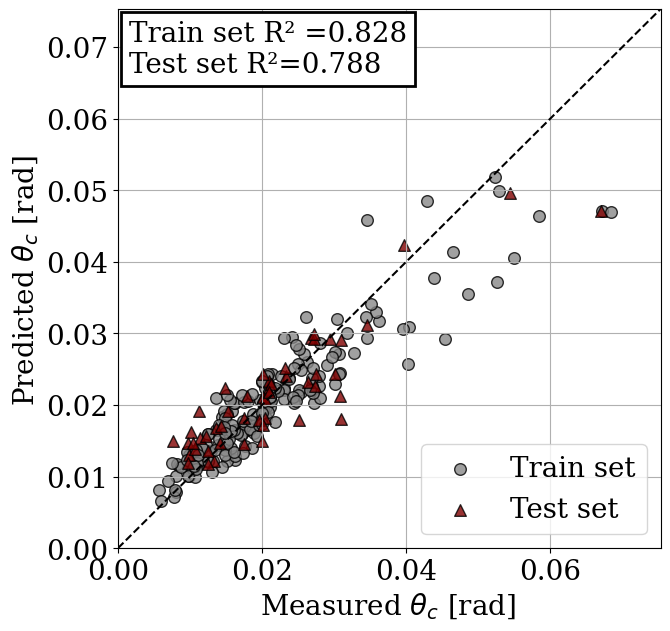

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
guide = np.max([np.max(inverse_result1.iloc[:,2]),np.max(inverse_result1.iloc[:,3]),np.max(inverse_result2.iloc[:,2]),np.max(inverse_result2.iloc[:,3])])*1.1
line_data = [0.0, guide]
line_test = [0.0, guide]
plt.figure(figsize=(7, 7))
plt.rc('font', size=20)
plt.margins(x=0, y=0)

actual_values = inverse_result1.iloc[:,2]
predicted_values = inverse_result1.iloc[:,3]
r_squared = r2_score(actual_values, predicted_values)

actual_values_c = inverse_result2.iloc[:,2]
predicted_values_c = inverse_result2.iloc[:,3]
r_squared_c = r2_score(actual_values_c, predicted_values_c)
# labels = ["$\\theta_y$", "$\\theta_c$", "$\\theta_u$", "$\\theta_f$","$F_y$","$F_c$", "$F_u$", "$F_f$"]
ax =  plt.scatter(actual_values, predicted_values,color="black", s=70, edgecolor="black", facecolors="#888888",alpha=0.8)
ax.set_label('Train set')
ax1 = plt.scatter(actual_values_c, predicted_values_c,  color="#880000", s=70, marker="^", edgecolor="black", facecolors="#800000",alpha=0.8)
ax1.set_label('Test set')

plt.xlabel("Measured $\\theta_c$ ​[rad]​")
plt.ylabel("Predicted $\\theta_c$ [rad]​​")

plt.plot(line_data, line_data, color="black", linestyle='dashed')
plt.legend(loc="lower right")
plt.grid()
# text = f"R-squared : {r_squared:.2f}\nR-squared after: {r_squared_c:.2f}"
bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=2)
plt.text(0.02, 0.98, f"Train set R² ={r_squared:.3f}\nTest set R²={r_squared_c:.3f}",
         bbox=bbox_props, transform=plt.gca().transAxes, ha="left", va="top")
plt.savefig('target1.png', format='png')
plt.show()



### target 2

In [ ]:
target_num=2
X_fs1,y_fs1,model_tu=gradual(target_num)

In [ ]:
X_fs1=X_fs1.drop([56,189,191,192],axis=0)
y_fs1=y_fs1.drop([56,189,191,192],axis=0)

In [ ]:
r2_test_best,y_test_pred_best,y_train_pred_best,y_test_best,y_train_best,df_index_test_best,df_index_train_best=model_eval_100(X_fs1,y_fs1,model_tu)

In [ ]:
X_train=X_fs1.loc[df_index_train_best]
y_train=y_fs1[df_index_train_best]
X_test=X_fs1.loc[df_index_test_best]
y_test=y_fs1[df_index_test_best]

In [ ]:
df_index_train, df_index_test=train_test_index2(X_fs1,y_fs1)
X_train=X_fs1.loc[df_index_train]
y_train=y_fs1[df_index_train]
X_test=X_fs1.loc[df_index_test]
y_test=y_fs1[df_index_test]
model_tu.fit(X_train, y_train)
# Predict on the test set
y_test_pred = model_tu.predict(X_test)
y_train_pred = model_tu.predict(X_train)
# Compute the R-squared for the test set
r2_train = r2_score(y_train,y_train_pred)
r2_test = r2_score(y_test,y_test_pred)

In [ ]:
# trian set : result_df1
# test set  : result_df2
result_df1,result_df2=result(X_train,y_train,X_test,y_test,df_index_train_best,df_index_test_best,model_tu) # 예측값
inverse_result1=inverse_transe1(result_df1,target_num)
inverse_result2=inverse_transe1(result_df2,target_num) # 예측값 역변환

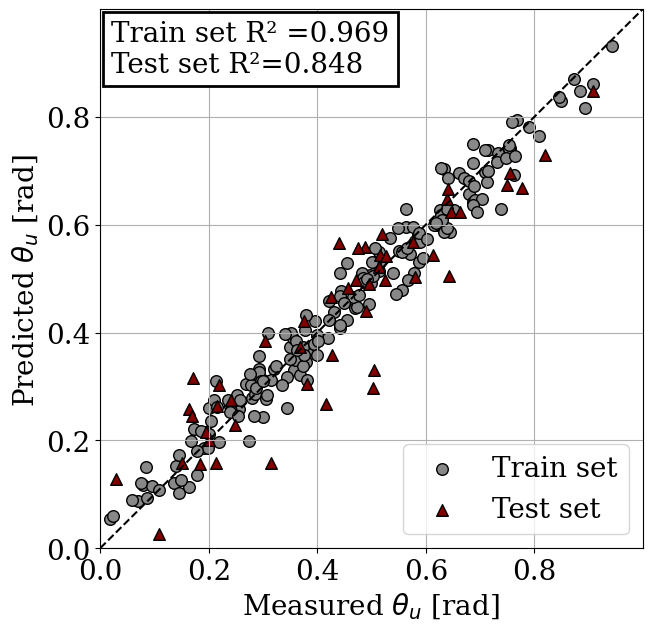

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
guide = np.max(y_test)*1.1
line_data = [0.0, guide]
line_test = [0.0, guide]
plt.figure(figsize=(7, 7))
plt.rc('font', size=20)
plt.margins(x=0, y=0)

actual_values = y_train
predicted_values =y_train_pred
r_squared = r2_score(actual_values, predicted_values)

actual_values_c = y_test
predicted_values_c = y_test_pred
r_squared_c = r2_score(actual_values_c, predicted_values_c)
# labels = ["$\\theta_y$", "$\\theta_c$", "$\\theta_u$", "$\\theta_f$","$F_y$","$F_c$", "$F_u$", "$F_f$"]
ax =  plt.scatter(actual_values, predicted_values,color="black", s=70, edgecolor="black", facecolors="#888888")
ax.set_label('Train set')
ax1 = plt.scatter(actual_values_c, predicted_values_c,  color="#880000", s=70, marker="^", edgecolor="black", facecolors="#800000")
ax1.set_label('Test set')

plt.xlabel("Measured $\\theta_u$ ​[rad]​")
plt.ylabel("Predicted $\\theta_u$ [rad]​​")
plt.plot(line_data, line_data, color="black", linestyle='dashed')
plt.legend(loc="lower right")
plt.grid()
# text = f"R-squared : {r_squared:.2f}\nR-squared after: {r_squared_c:.2f}"
bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=2)
plt.text(0.02, 0.98, f"Train set R² ={r_squared:.3f}\nTest set R²={r_squared_c:.3f}",
         bbox=bbox_props, transform=plt.gca().transAxes, ha="left", va="top")
# plt.savefig('target2.png', format='png')
plt.show()



train vs test

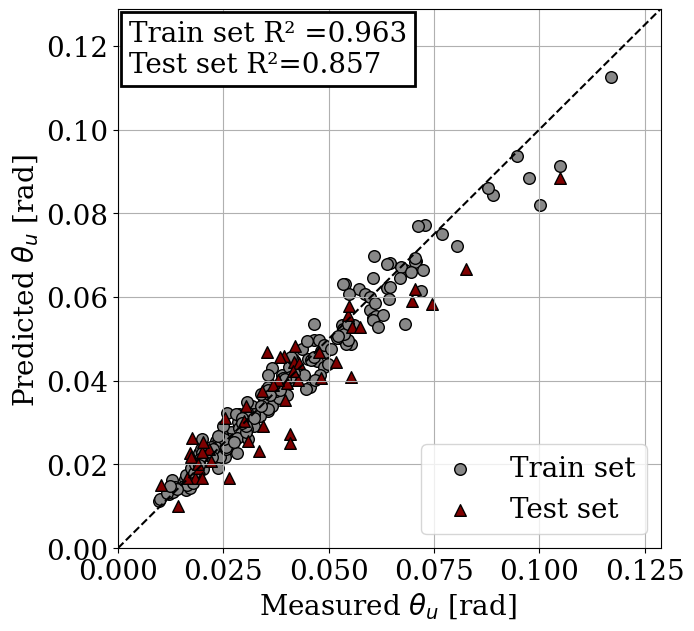

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
guide = np.max([np.max(inverse_result1.iloc[:,2]),np.max(inverse_result1.iloc[:,3])])*1.1
line_data = [0.0, guide]
line_test = [0.0, guide]
plt.figure(figsize=(7, 7))
plt.rc('font', size=20)
plt.margins(x=0, y=0)

actual_values = inverse_result1.iloc[:,2]
predicted_values = inverse_result1.iloc[:,3]
r_squared = r2_score(actual_values, predicted_values)

actual_values_c = inverse_result2.iloc[:,2]
predicted_values_c = inverse_result2.iloc[:,3]
r_squared_c = r2_score(actual_values_c, predicted_values_c)
# labels = ["$\\theta_y$", "$\\theta_c$", "$\\theta_u$", "$\\theta_f$","$F_y$","$F_c$", "$F_u$", "$F_f$"]
ax =  plt.scatter(actual_values, predicted_values,color="black", s=70, edgecolor="black", facecolors="#888888")
ax.set_label('Train set')
ax1 = plt.scatter(actual_values_c, predicted_values_c,  color="#880000", s=70, marker="^", edgecolor="black", facecolors="#800000")
ax1.set_label('Test set')

plt.xlabel("Measured $\\theta_u$ ​[rad]​")
plt.ylabel("Predicted $\\theta_u$ [rad]​​")
plt.plot(line_data, line_data, color="black", linestyle='dashed')
plt.legend(loc="lower right")
plt.grid()
# text = f"R-squared : {r_squared:.2f}\nR-squared after: {r_squared_c:.2f}"
bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=2)
plt.text(0.02, 0.98, f"Train set R² ={r_squared:.3f}\nTest set R²={r_squared_c:.3f}",
         bbox=bbox_props, transform=plt.gca().transAxes, ha="left", va="top")
# plt.savefig('target2.png', format='png')
plt.show()



### target 3

In [ ]:
target_num=3
X_fs1,y_fs1,model_tu=gradual(target_num)

In [ ]:
r2_test_best,y_test_pred_best,y_train_pred_best,y_test_best,y_train_best,df_index_test_best,df_index_train_best=model_eval_100(X_fs1,y_fs1,model_tu)

In [ ]:
X_train=X_fs1.loc[df_index_train_best]
y_train=y_fs1[df_index_train_best]
X_test=X_fs1.loc[df_index_test_best]
y_test=y_fs1[df_index_test_best]

In [ ]:
# trian set : result_df1
# test set  : result_df2
result_df1,result_df2=result(X_train,y_train,X_test,y_test,df_index_train_best,df_index_test_best,model_tu) # 예측값
inverse_result1=inverse_transe1(result_df1,target_num)
inverse_result2=inverse_transe1(result_df2,target_num) # 예측값 역변환

In [ ]:
inverse_result1

,index,test,inverse,preds
1,1,247.64,247.64,243.486816
5,5,109.46,109.46,103.592140
6,6,55.08,55.08,73.327454
7,7,241.58,241.58,271.195801
9,9,120.82,120.82,120.110779
...,...,...,...,...
270,270,118.73,118.73,130.960480
271,271,136.79,136.79,142.382278
272,272,195.96,195.96,156.384140
273,273,203.64,203.64,208.534683


train vs test

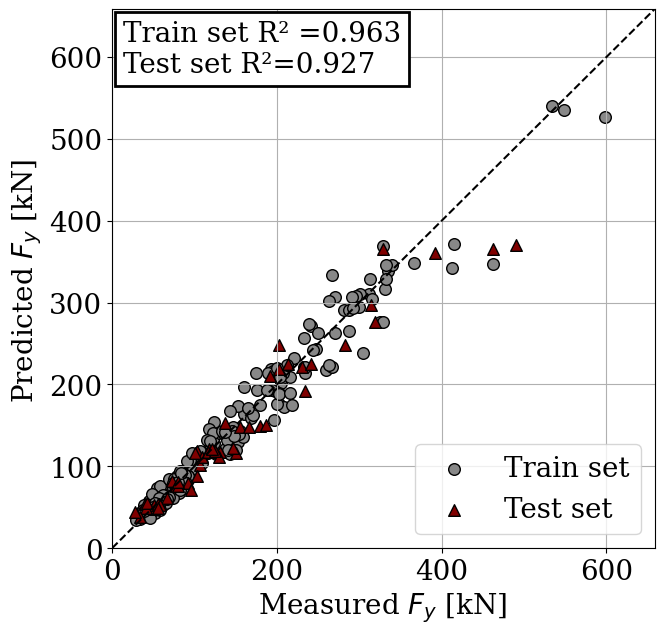

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
guide = np.max([np.max(inverse_result1.iloc[:,2]),np.max(inverse_result1.iloc[:,3])])*1.1
line_data = [0.0, guide]
line_test = [0.0, guide]
plt.figure(figsize=(7, 7))
plt.rc('font', size=20)
plt.margins(x=0, y=0)

actual_values = inverse_result1.iloc[:,2]
predicted_values = inverse_result1.iloc[:,3]
r_squared = r2_score(actual_values, predicted_values)

actual_values_c = inverse_result2.iloc[:,2]
predicted_values_c = inverse_result2.iloc[:,3]
r_squared_c = r2_score(actual_values_c, predicted_values_c)
# labels = ["$\\theta_y$", "$\\theta_c$", "$\\theta_u$", "$\\theta_f$","$F_y$","$F_c$", "$F_u$", "$F_f$"]
ax =  plt.scatter(actual_values, predicted_values,color="black", s=70, edgecolor="black", facecolors="#888888")
ax.set_label('Train set')
ax1 = plt.scatter(actual_values_c, predicted_values_c,  color="#880000", s=70, marker="^", edgecolor="black", facecolors="#800000")
ax1.set_label('Test set')

plt.xlabel("Measured $F_y$ ​[kN]​")
plt.ylabel("Predicted $F_y$ [kN]​​")

plt.plot(line_data, line_data, color="black", linestyle='dashed')
plt.legend(loc="lower right")
plt.grid()
# text = f"R-squared : {r_squared:.2f}\nR-squared after: {r_squared_c:.2f}"
bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=2)
plt.text(0.02, 0.98, f"Train set R² ={r_squared:.3f}\nTest set R²={r_squared_c:.3f}",
         bbox=bbox_props, transform=plt.gca().transAxes, ha="left", va="top")
plt.savefig('target3.png', format='png')
plt.show()



### target 4

In [ ]:
target_num=4
X_fs1,y_fs1,model_tu=gradual(target_num)

In [ ]:
r2_test_best,y_test_pred_best,y_train_pred_best,y_test_best,y_train_best,df_index_test_best,df_index_train_best=model_eval_100(X_fs1,y_fs1,model_tu)

In [ ]:
X_train=X_fs1.loc[df_index_train_best]
y_train=y_fs1[df_index_train_best]
X_test=X_fs1.loc[df_index_test_best]
y_test=y_fs1[df_index_test_best]

In [ ]:
# trian set : result_df1
# test set  : result_df2
result_df1,result_df2=result(X_train,y_train,X_test,y_test,df_index_train_best,df_index_test_best,model_tu) # 예측값
inverse_result1=inverse_transe1(result_df1,target_num)
inverse_result2=inverse_transe1(result_df2,target_num) # 예측값 역변환

train vs test

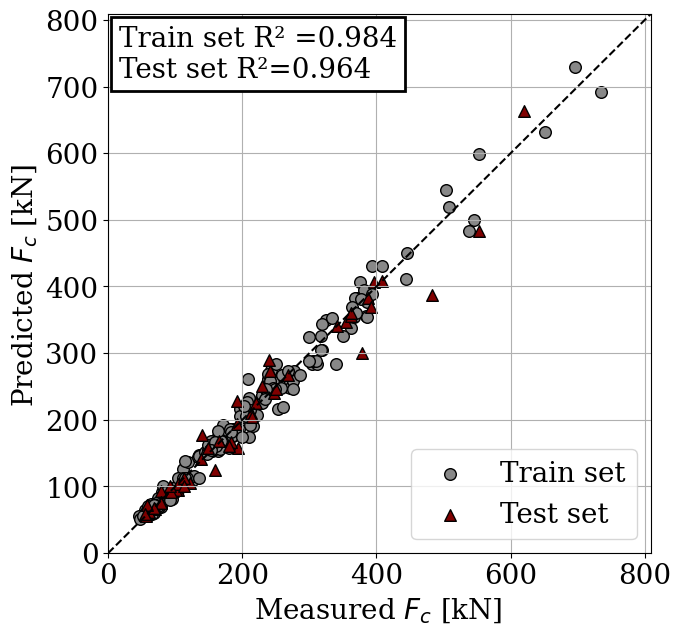

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
guide = np.max([np.max(inverse_result1.iloc[:,2]),np.max(inverse_result1.iloc[:,3])])*1.1
line_data = [0.0, guide]
line_test = [0.0, guide]
plt.figure(figsize=(7, 7))
plt.rc('font', size=20)
plt.margins(x=0, y=0)

actual_values = inverse_result1.iloc[:,2]
predicted_values = inverse_result1.iloc[:,3]
r_squared = r2_score(actual_values, predicted_values)

actual_values_c = inverse_result2.iloc[:,2]
predicted_values_c = inverse_result2.iloc[:,3]
r_squared_c = r2_score(actual_values_c, predicted_values_c)
# labels = ["$\\theta_y$", "$\\theta_c$", "$\\theta_u$", "$\\theta_f$","$F_y$","$F_c$", "$F_u$", "$F_f$"]
ax =  plt.scatter(actual_values, predicted_values,color="black", s=70, edgecolor="black", facecolors="#888888")
ax.set_label('Train set')
ax1 = plt.scatter(actual_values_c, predicted_values_c,  color="#880000", s=70, marker="^", edgecolor="black", facecolors="#800000")
ax1.set_label('Test set')

plt.xlabel("Measured $F_c$ ​[kN]​")
plt.ylabel("Predicted $F_c$ [kN]​​")

plt.plot(line_data, line_data, color="black", linestyle='dashed')
plt.legend(loc="lower right")
plt.grid()
# text = f"R-squared : {r_squared:.2f}\nR-squared after: {r_squared_c:.2f}"
bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=2)
plt.text(0.02, 0.98, f"Train set R² ={r_squared:.3f}\nTest set R²={r_squared_c:.3f}",
         bbox=bbox_props, transform=plt.gca().transAxes, ha="left", va="top")
plt.savefig('target4.png', format='png')
plt.show()



### target 5

In [ ]:
target_num=5
X_fs1,y_fs1,model_tu=gradual(target_num)

In [ ]:
r2_test_best,y_test_pred_best,y_train_pred_best,y_test_best,y_train_best,df_index_test_best,df_index_train_best=model_eval_100(X_fs1,y_fs1,model_tu)

In [ ]:
X_train=X_fs1.loc[df_index_train_best]
y_train=y_fs1[df_index_train_best]
X_test=X_fs1.loc[df_index_test_best]
y_test=y_fs1[df_index_test_best]

In [ ]:
# trian set : result_df1
# test set  : result_df2
result_df1,result_df2=result(X_train,y_train,X_test,y_test,df_index_train_best,df_index_test_best,model_tu) # 예측값
inverse_result1=inverse_transe1(result_df1,target_num)
inverse_result2=inverse_transe1(result_df2,target_num) # 예측값 역변환

train vs test

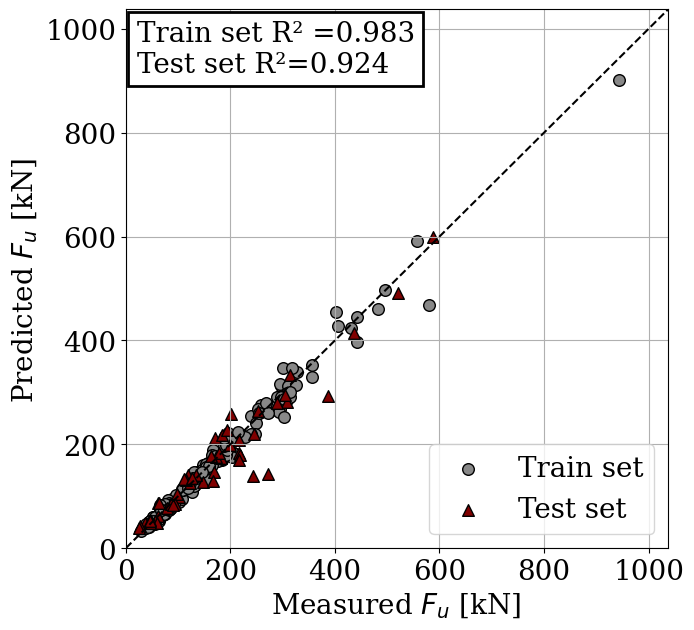

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
guide = np.max([np.max(inverse_result1.iloc[:,2]),np.max(inverse_result1.iloc[:,3])])*1.1
line_data = [0.0, guide]
line_test = [0.0, guide]
plt.figure(figsize=(7, 7))
plt.rc('font', size=20)
plt.margins(x=0, y=0)

actual_values = inverse_result1.iloc[:,2]
predicted_values = inverse_result1.iloc[:,3]
r_squared = r2_score(actual_values, predicted_values)

actual_values_c = inverse_result2.iloc[:,2]
predicted_values_c = inverse_result2.iloc[:,3]
r_squared_c = r2_score(actual_values_c, predicted_values_c)
# labels = ["$\\theta_y$", "$\\theta_c$", "$\\theta_u$", "$\\theta_f$","$F_y$","$F_c$", "$F_u$", "$F_f$"]
ax =  plt.scatter(actual_values, predicted_values,color="black", s=70, edgecolor="black", facecolors="#888888")
ax.set_label('Train set')
ax1 = plt.scatter(actual_values_c, predicted_values_c,  color="#880000", s=70, marker="^", edgecolor="black", facecolors="#800000")
ax1.set_label('Test set')

plt.xlabel("Measured $F_u$ ​[kN]​")
plt.ylabel("Predicted $F_u$ [kN]​​")

plt.plot(line_data, line_data, color="black", linestyle='dashed')
plt.legend(loc="lower right")
plt.grid()
# text = f"R-squared : {r_squared:.2f}\nR-squared after: {r_squared_c:.2f}"
bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=2)
plt.text(0.02, 0.98, f"Train set R² ={r_squared:.3f}\nTest set R²={r_squared_c:.3f}",
         bbox=bbox_props, transform=plt.gca().transAxes, ha="left", va="top")
plt.savefig('target5.png', format='png')
plt.show()



### target 6

In [ ]:
target_num=6
X_fs1,y_fs1,model_tu=gradual(target_num)

In [ ]:
r2_test_best,y_test_pred_best,y_train_pred_best,y_test_best,y_train_best,df_index_test_best,df_index_train_best=model_eval_100(X_fs1,y_fs1,model_tu)

In [ ]:
X_train=X_fs1.loc[df_index_train_best]
y_train=y_fs1[df_index_train_best]
X_test=X_fs1.loc[df_index_test_best]
y_test=y_fs1[df_index_test_best]

In [ ]:
# trian set : result_df1
# test set  : result_df2
result_df1,result_df2=result(X_train,y_train,X_test,y_test,df_index_train_best,df_index_test_best,model_tu) # 예측값
inverse_result1=inverse_transe1(result_df1,target_num)
inverse_result2=inverse_transe1(result_df2,target_num) # 예측값 역변환

train vs test

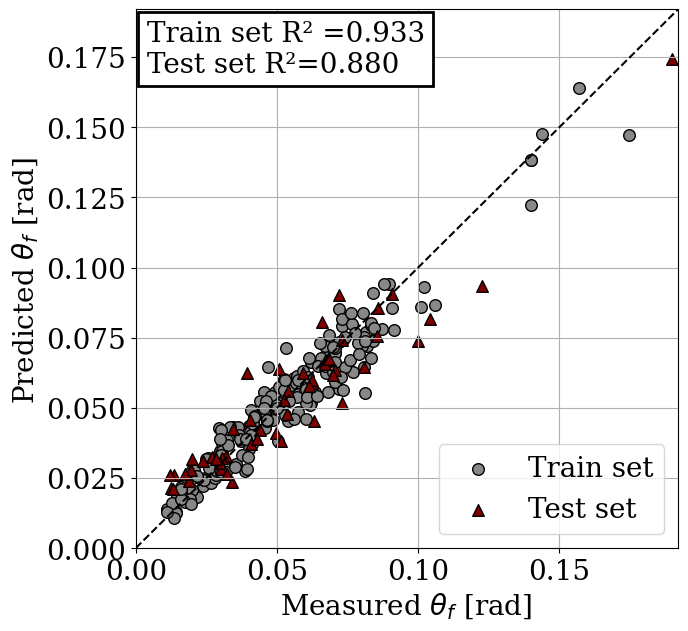

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
guide = np.max([np.max(inverse_result1.iloc[:,2]),np.max(inverse_result1.iloc[:,3])])*1.1
line_data = [0.0, guide]
line_test = [0.0, guide]
plt.figure(figsize=(7, 7))
plt.rc('font', size=20)
plt.margins(x=0, y=0)

actual_values = inverse_result1.iloc[:,2]
predicted_values = inverse_result1.iloc[:,3]
r_squared = r2_score(actual_values, predicted_values)

actual_values_c = inverse_result2.iloc[:,2]
predicted_values_c = inverse_result2.iloc[:,3]
r_squared_c = r2_score(actual_values_c, predicted_values_c)
# labels = ["$\\theta_y$", "$\\theta_c$", "$\\theta_u$", "$\\theta_f$","$F_y$","$F_c$", "$F_u$", "$F_f$"]
ax =  plt.scatter(actual_values, predicted_values,color="black", s=70, edgecolor="black", facecolors="#888888")
ax.set_label('Train set')
ax1 = plt.scatter(actual_values_c, predicted_values_c,  color="#880000", s=70, marker="^", edgecolor="black", facecolors="#800000")
ax1.set_label('Test set')

plt.xlabel("Measured $\\theta_f$ ​[rad]​")
plt.ylabel("Predicted $\\theta_f$ [rad]​​")

plt.plot(line_data, line_data, color="black", linestyle='dashed')
plt.legend(loc="lower right")
plt.grid()
# text = f"R-squared : {r_squared:.2f}\nR-squared after: {r_squared_c:.2f}"
bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=2)
plt.text(0.02, 0.98, f"Train set R² ={r_squared:.3f}\nTest set R²={r_squared_c:.3f}",
         bbox=bbox_props, transform=plt.gca().transAxes, ha="left", va="top")
plt.savefig('target6.png', format='png')
plt.show()



### target 7

In [ ]:
target_num=7
X_fs1,y_fs1,model_tu=gradual(target_num)

In [ ]:
r2_test_best,y_test_pred_best,y_train_pred_best,y_test_best,y_train_best,df_index_test_best,df_index_train_best=model_eval_100(X_fs1,y_fs1,model_tu)

In [ ]:
X_train=X_fs1.loc[df_index_train_best]
y_train=y_fs1[df_index_train_best]
X_test=X_fs1.loc[df_index_test_best]
y_test=y_fs1[df_index_test_best]

In [ ]:
# trian set : result_df1
# test set  : result_df2
result_df1,result_df2=result(X_train,y_train,X_test,y_test,df_index_train_best,df_index_test_best,model_tu) # 예측값
inverse_result1=inverse_transe1(result_df1,target_num)
inverse_result2=inverse_transe1(result_df2,target_num) # 예측값 역변환

train vs test

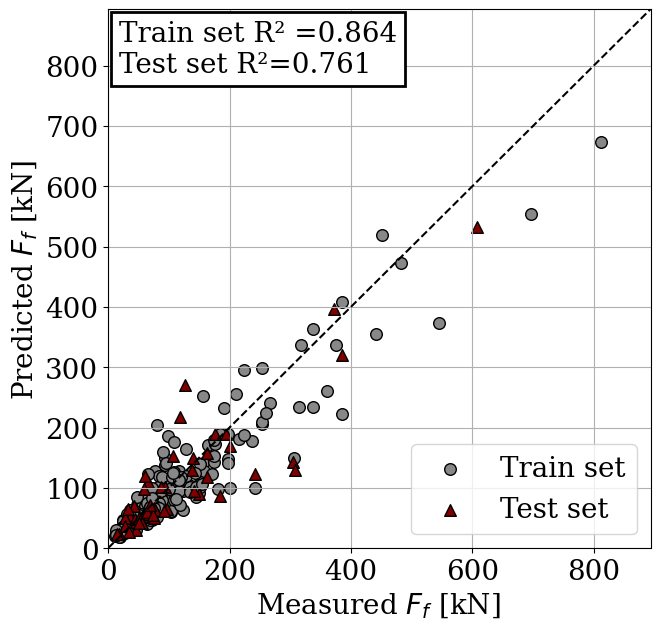

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
guide = np.max([np.max(inverse_result1.iloc[:,2]),np.max(inverse_result1.iloc[:,3])])*1.1
line_data = [0.0, guide]
line_test = [0.0, guide]
plt.figure(figsize=(7, 7))
plt.rc('font', size=20)
plt.margins(x=0, y=0)

actual_values = inverse_result1.iloc[:,2]
predicted_values = inverse_result1.iloc[:,3]
r_squared = r2_score(actual_values, predicted_values)

actual_values_c = inverse_result2.iloc[:,2]
predicted_values_c = inverse_result2.iloc[:,3]
r_squared_c = r2_score(actual_values_c, predicted_values_c)
# labels = ["$\\theta_y$", "$\\theta_c$", "$\\theta_u$", "$\\theta_f$","$F_y$","$F_c$", "$F_u$", "$F_f$"]
ax =  plt.scatter(actual_values, predicted_values,color="black", s=70, edgecolor="black", facecolors="#888888")
ax.set_label('Train set')
ax1 = plt.scatter(actual_values_c, predicted_values_c,  color="#880000", s=70, marker="^", edgecolor="black", facecolors="#800000")
ax1.set_label('Test set')

plt.xlabel("Measured $F_f$ ​[kN]​")
plt.ylabel("Predicted $F_f$ [kN]​​")

plt.plot(line_data, line_data, color="black", linestyle='dashed')
plt.legend(loc="lower right")
plt.grid()
# text = f"R-squared : {r_squared:.2f}\nR-squared after: {r_squared_c:.2f}"
bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=2)
plt.text(0.02, 0.98, f"Train set R² ={r_squared:.3f}\nTest set R²={r_squared_c:.3f}",
         bbox=bbox_props, transform=plt.gca().transAxes, ha="left", va="top")
plt.savefig('target7.png', format='png')
plt.show()



## a,b,c 예측-실제값 뽑기

In [ ]:
df= pd.read_csv("df_275samples_1107.csv", encoding='cp949')
df_output=df.iloc[:, -3:]
df_input=df.iloc[:,:-3]

In [34]:
asce=pd.read_csv("asce_compare.csv",encoding='cp949')

In [ ]:
def gradual(target_num):
  rsod_para=pd.read_csv("rsod_parameters_1107.csv",encoding='cp949')
  df= pd.read_csv("df_275samples_1107.csv", encoding='cp949')
  df_output=df.iloc[:, -3:]
  df_input=df.iloc[:,:-3]
  X = df_input
  y = df_output.iloc[:,target_num]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None,shuffle=True)
  model = XGBRegressor(objective='reg:squarederror',base_score=np.median(y))
  model.fit(X_train,y_train)
  ##데이터전처리##
  X_dp,y_dp=data_input(target_num)
  X_train, X_test, y_train, y_test = train_test_split(X_dp, y_dp, test_size=0.2, random_state=None,shuffle=True)
  df_index_test=sorted(X_test.index.tolist())
  df_index_train=sorted(X_train.index.tolist())
  model = XGBRegressor(objective='reg:squarederror',base_score=np.median(y_dp))
  model.fit(X_train,y_train)
  ##초기튜닝##
  model_it=initial_tunning_pso(X_train, X_test, y_train, y_test)
  X_test=X_dp.loc[df_index_test,:]
  y_test=y_dp.loc[df_index_test]
  X_train=X_dp.loc[df_index_train,:]
  y_train=y_dp.loc[df_index_train]
  #이상치제거
  X_rsod,y_rsod,real_remove_df=outlier_eliminater(X_dp,y_dp,5,rsod_para.iloc[target_num,0],rsod_para.iloc[target_num,1],rsod_para.iloc[target_num,2],model_it)
  X_train, X_test, y_train, y_test = train_test_split(X_rsod, y_rsod, test_size=0.2, random_state=None,shuffle=True)
  df_index_test=sorted(X_test.index.tolist())
  df_index_train=sorted(X_train.index.tolist())
  model_it=initial_tunning_pso(X_train, X_test, y_train, y_test)
  #변수선택
  X_fs1,y_fs1,indices=fs1(X_rsod,y_rsod,model_it,100) # feature 줄이기
  X_test=X_fs1.loc[df_index_test,:]
  y_test=y_fs1.loc[df_index_test]
  X_train=X_fs1.loc[df_index_train,:]
  y_train=y_fs1.loc[df_index_train]
  # model_fsit=initial_tunning_pso(X_train, X_test, y_train, y_test)
  #튜닝
  model_tu=tunning_pso(X_train,y_train,X_test,y_test)
  return X_fs1,y_fs1,model_tu

In [ ]:
asce.loc[df_index_test_best,:].iloc[:,target_num]

NameError: ignored

In [ ]:
target_num=2
X_fs1,y_fs1,model_tu=gradual(target_num)

In [ ]:
r2_test_best,y_test_pred_best,y_train_pred_best,y_test_best,y_train_best,df_index_test_best,df_index_train_best=model_eval_100(X_fs1,y_fs1,model_tu)

In [ ]:
r2_test_best

0.8560436322741214

In [ ]:
X_train=X_fs1.loc[df_index_train_best]
y_train=y_fs1[df_index_train_best]
X_test=X_fs1.loc[df_index_test_best]
y_test=y_fs1[df_index_test_best]

In [ ]:
# trian set : result_df1
# test set  : result_df2
result_df1,result_df2=result(X_train,y_train,X_test,y_test,df_index_train_best,df_index_test_best,model_tu) # 예측값
inverse_result1=inverse_transe(result_df1,target_num)
inverse_result2=inverse_transe(result_df2,target_num) # 예측값 역변환

train vs test

In [ ]:
asce

,0,1,2
0,0.027935,0.061408,12.55772
1,0.029241,0.059343,52.49968
2,0.006783,0.090000,0.00000
3,0.002314,0.090000,0.00000
4,0.004287,0.090000,0.00000
...,...,...,...
270,0.020983,0.024128,25.17076
271,0.018814,0.018814,25.16936
272,0.011419,0.011419,30.56976
273,0.012203,0.012203,37.46976


In [ ]:
inverse_result1.to_csv("inverse_result1a.csv")
inverse_result2.to_csv("inverse_result2a.csv")

In [ ]:
inverse_result1.to_csv("inverse_result1b.csv")
inverse_result2.to_csv("inverse_result2b.csv")

In [ ]:
inverse_result1.to_csv("inverse_result1c.csv")
inverse_result2.to_csv("inverse_result2c.csv")

In [32]:
inverse_result1a=pd.read_csv("inverse_result1a.csv", encoding='cp949',index_col=0)
inverse_result2a=pd.read_csv("inverse_result2a.csv", encoding='cp949',index_col=0)

inverse_result1b=pd.read_csv("inverse_result1b.csv", encoding='cp949',index_col=0)
inverse_result2b=pd.read_csv("inverse_result2b.csv", encoding='cp949',index_col=0)

inverse_result1c=pd.read_csv("inverse_result1c.csv", encoding='cp949',index_col=0)
inverse_result2c=pd.read_csv("inverse_result2c.csv", encoding='cp949',index_col=0)

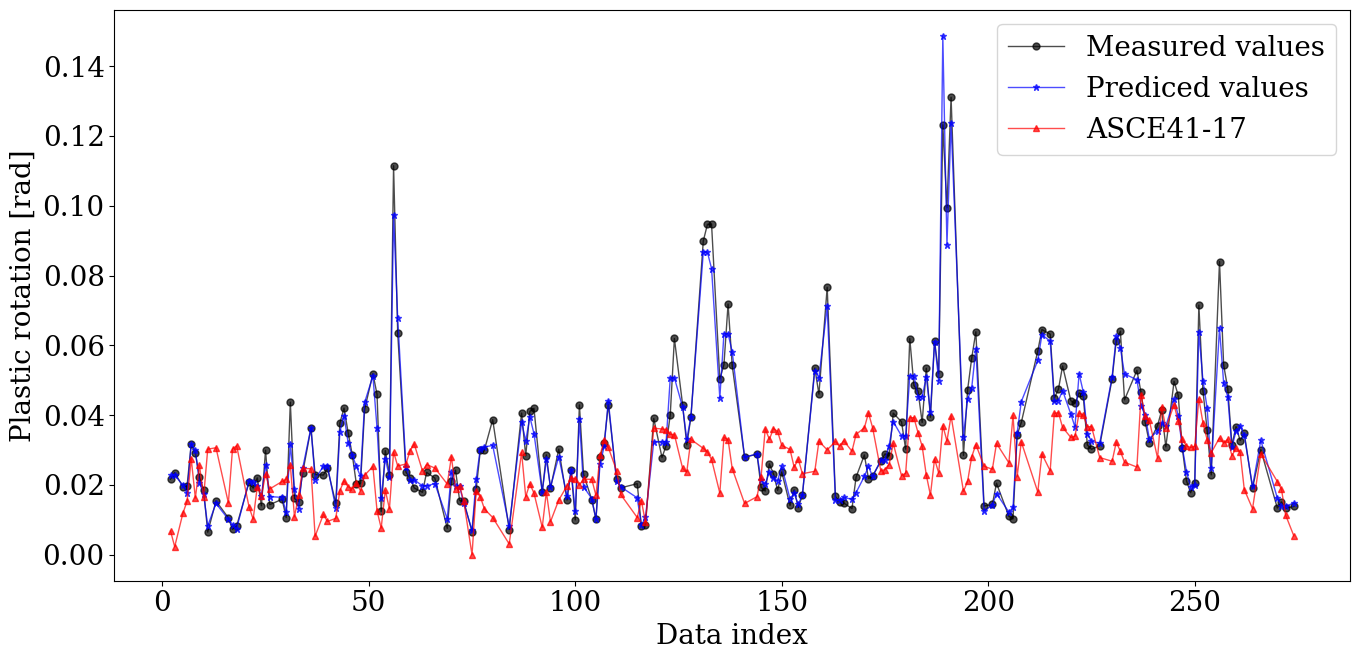

In [37]:
plt.figure(figsize=(14, 7))
plt.rc('font', size=20)
plt.plot(inverse_result1a.iloc[:, 0], inverse_result1a.iloc[:, 1], '-o', color='black', alpha=0.7, label='Measured values', linewidth=1, ms=5)
plt.plot(inverse_result1a.iloc[:, 0], inverse_result1a.iloc[:, 3], '-*', color='blue', alpha=0.7, label='Prediced values', linewidth=1, ms=5)
plt.plot(inverse_result1a.iloc[:, 0], asce.loc[inverse_result1a.index,'0'], '-^', color='red', alpha=0.7, label='ASCE41-17', linewidth=1, ms=5)
plt.legend()
plt.xlabel("Data index​")
plt.ylabel("Plastic rotation [rad]​")
plt.tight_layout()
plt.show()

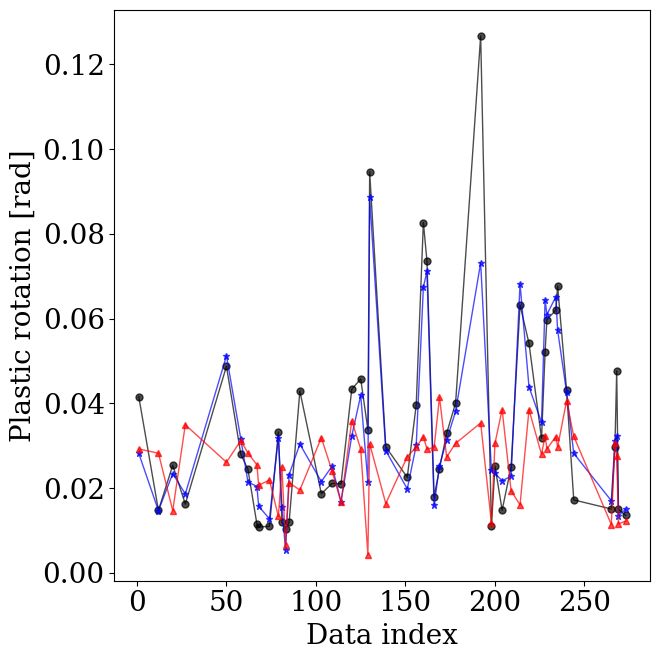

In [ ]:
plt.figure(figsize=(14, 7))
plt.rc('font', size=20)
plt.plot(inverse_result2a.iloc[:, 0], inverse_result2a.iloc[:, 1], '-o', color='black', alpha=0.7, label='Measured values', linewidth=1, ms=5)
plt.plot(inverse_result2a.iloc[:, 0], inverse_result2a.iloc[:, 3], '-*', color='blue', alpha=0.7, label='Prediced values', linewidth=1, ms=5)
plt.plot(inverse_result2a.iloc[:, 0], asce.loc[inverse_result2a.index,'0'], '-^', color='red', alpha=0.7, label='ASCE41-17', linewidth=1, ms=5)
# plt.legend()
plt.xlabel("Data index​")
plt.ylabel("Plastic rotation [rad]​")
plt.tight_layout()
plt.show()

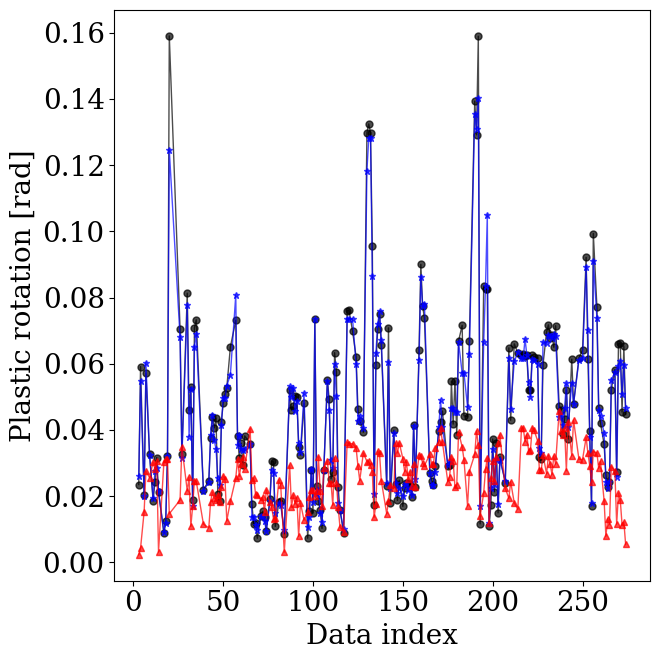

In [ ]:
plt.figure(figsize=(14, 7))
plt.rc('font', size=20)
plt.plot(inverse_result1b.iloc[:, 0], inverse_result1b.iloc[:, 1], '-o', color='black', alpha=0.7, label='Measured "b"', linewidth=1, ms=5)
plt.plot(inverse_result1b.iloc[:, 0], inverse_result1b.iloc[:, 3], '-*', color='blue', alpha=0.7, label='Prediced "b"', linewidth=1, ms=5)
plt.plot(inverse_result1b.iloc[:, 0], asce.loc[inverse_result1b.index,'0'], '-^', color='red', alpha=0.7, label='ASCE41-17', linewidth=1, ms=5)
# plt.legend()
plt.xlabel("Data index​")
plt.ylabel("Plastic rotation [rad]​")
plt.tight_layout()
plt.show()

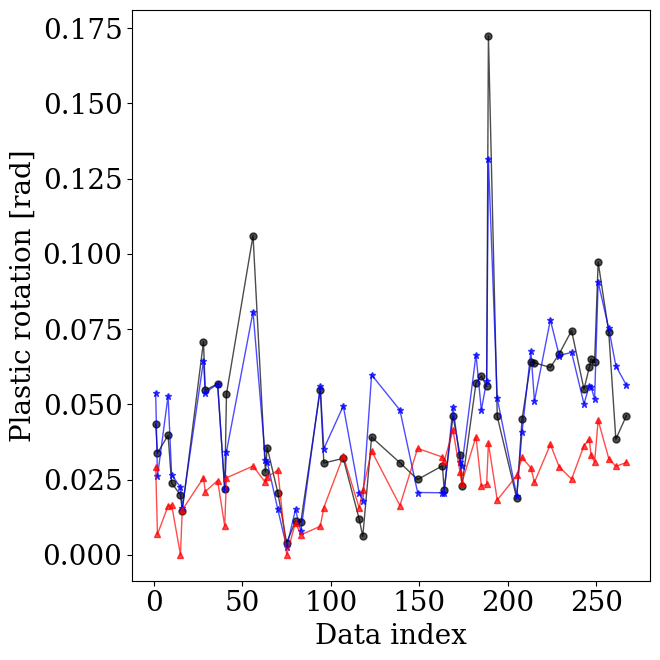

In [ ]:
plt.figure(figsize=(14, 7))
plt.rc('font', size=20)
plt.plot(inverse_result2b.iloc[:, 0], inverse_result2b.iloc[:, 1], '-o', color='black', alpha=0.7, label='Measured "b"', linewidth=1, ms=5)
plt.plot(inverse_result2b.iloc[:, 0], inverse_result2b.iloc[:, 3], '-*', color='blue', alpha=0.7, label='Prediced "b"', linewidth=1, ms=5)
plt.plot(inverse_result2b.iloc[:, 0], asce.loc[inverse_result2b.index,'0'], '-^', color='red', alpha=0.7, label='ASCE41-17', linewidth=1, ms=5)
# plt.legend()
plt.xlabel("Data index​")
plt.ylabel("Plastic rotation [rad]​")
plt.tight_layout()
plt.show()

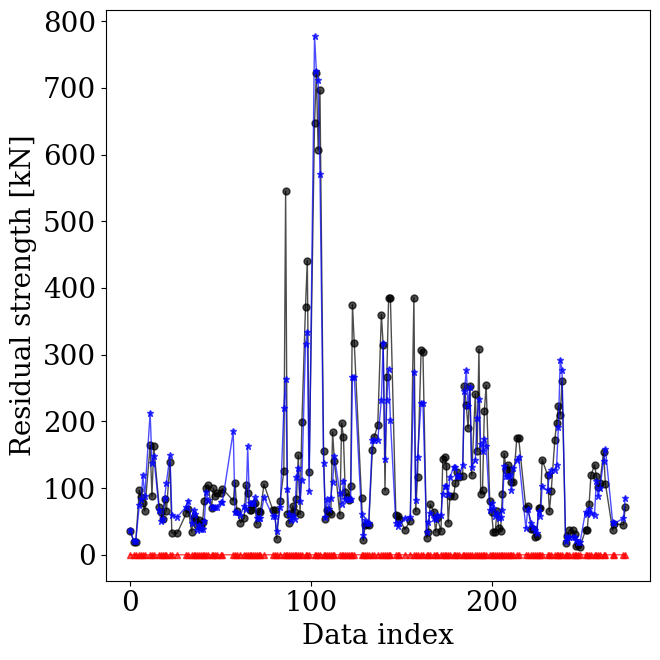

In [ ]:
plt.figure(figsize=(14, 7))
plt.rc('font', size=20)
plt.plot(inverse_result1c.iloc[:, 0], inverse_result1c.iloc[:, 1], '-o', color='black', alpha=0.7, label='Measured "c"', linewidth=1, ms=5)
plt.plot(inverse_result1c.iloc[:, 0], inverse_result1c.iloc[:, 3], '-*', color='blue', alpha=0.7, label='Prediced "c"', linewidth=1, ms=5)
plt.plot(inverse_result1c.iloc[:, 0], asce.loc[inverse_result1c.index,'0'], '-^', color='red', alpha=0.7, label='ASCE41-17', linewidth=1, ms=5)
# plt.legend()
plt.xlabel("Data index​")
plt.ylabel("Residual strength [kN]​")
plt.tight_layout()
plt.show()

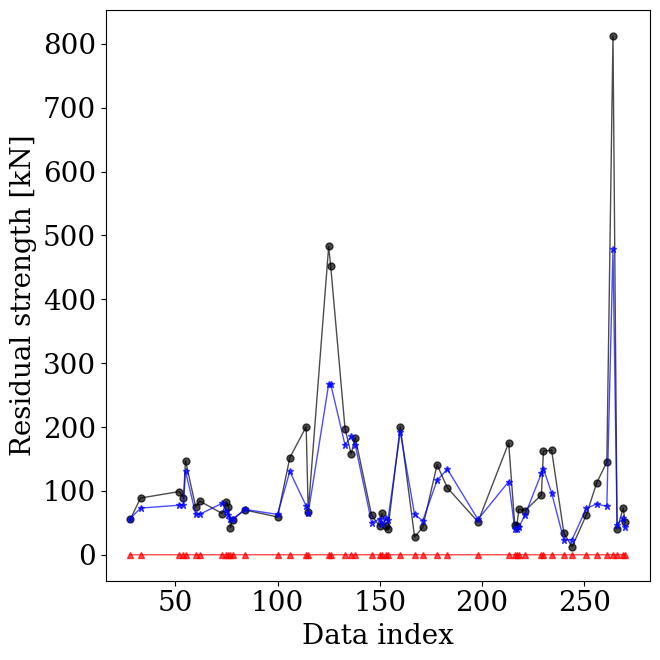

In [ ]:
plt.figure(figsize=(14, 7))
plt.rc('font', size=20)
plt.plot(inverse_result2c.iloc[:, 0], inverse_result2c.iloc[:, 1], '-o', color='black', alpha=0.7, label='Measured "c"', linewidth=1, ms=5)
plt.plot(inverse_result2c.iloc[:, 0], inverse_result2c.iloc[:, 3], '-*', color='blue', alpha=0.7, label='Prediced "c"', linewidth=1, ms=5)
plt.plot(inverse_result2c.iloc[:, 0], asce.loc[inverse_result2c.index,'0'], '-^', color='red', alpha=0.7, label='ASCE41-17', linewidth=1, ms=5)
# plt.legend()
plt.xlabel("Data index​")
plt.ylabel("Residual strength [kN]​")
plt.tight_layout()
plt.show()

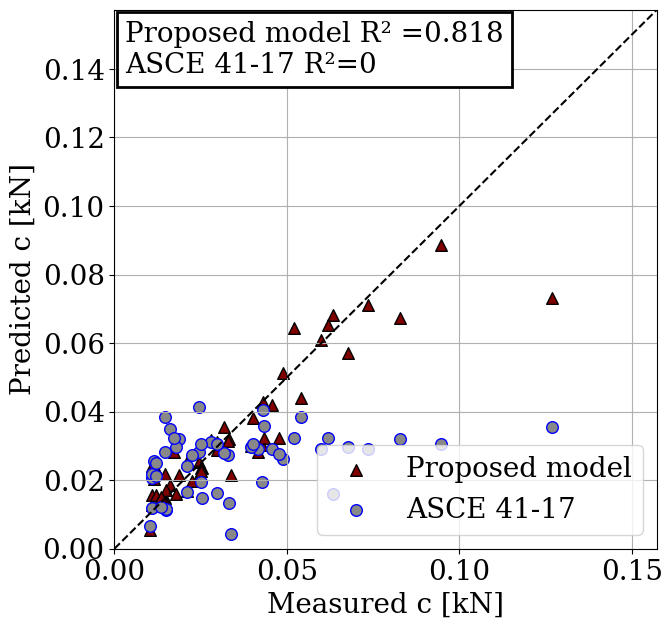

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

target_name=["a","b","c"]
# guide = np.max([np.max(inverse_result1.iloc[:,2]),np.max(inverse_result1.iloc[:,3]),np.max(asce.loc[df_index_test_best,:].iloc[:,target_num])])*1.1
guide = np.max([np.max(inverse_result1.iloc[:,2]),np.max(asce.loc[df_index_test_best,:].iloc[:,target_num])])*1.2
line_data = [0.0, guide]
line_test = [0.0, guide]
plt.figure(figsize=(7, 7))
plt.rc('font', size=20)
plt.margins(x=0, y=0)

actual_values = inverse_result2.iloc[:,2]
predicted_values = inverse_result2.iloc[:,3]
r_squared = r2_score(actual_values, predicted_values)

actual_values_c = inverse_result2.iloc[:,2]
predicted_values_c = asce.loc[df_index_test_best,:].iloc[:,target_num]
r_squared_c = r2_score(actual_values_c, predicted_values_c)

ax =  plt.scatter(actual_values, predicted_values, color="#880000", s=70, marker="^", edgecolor="black", facecolors="#800000")
ax.set_label('Proposed model')
ax1 = plt.scatter(actual_values_c, predicted_values_c, color="blue", s=70, edgecolor="blue", facecolors="#888888")
ax1.set_label('ASCE 41-17')

# plt.xlabel("Measured drift ratio ​[rad]​")
# plt.ylabel("Predicted drift ratio [rad]​​")
plt.xlabel("Measured c ​[kN]​")
plt.ylabel("Predicted c ​[kN]​")

plt.plot(line_data, line_data, color="black", linestyle='dashed')
plt.legend(loc="lower right")
plt.grid()
# text = f"R-squared : {r_squared:.2f}\nR-squared after: {r_squared_c:.2f}"
bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=2)
plt.text(0.02, 0.98, f"Proposed model R² ={r_squared:.3f}\nASCE 41-17 R²={0}",
# plt.text(0.02, 0.98, f"Proposed model R² ={r_squared:.3f}\nASCE 41-17 R²={r_squared_c:.3f}",
         bbox=bbox_props, transform=plt.gca().transAxes, ha="left", va="top")
# plt.xticks(np.arange(0, guide, 0.02))
# plt.yticks(np.arange(0, guide, 0.02))
plt.show()



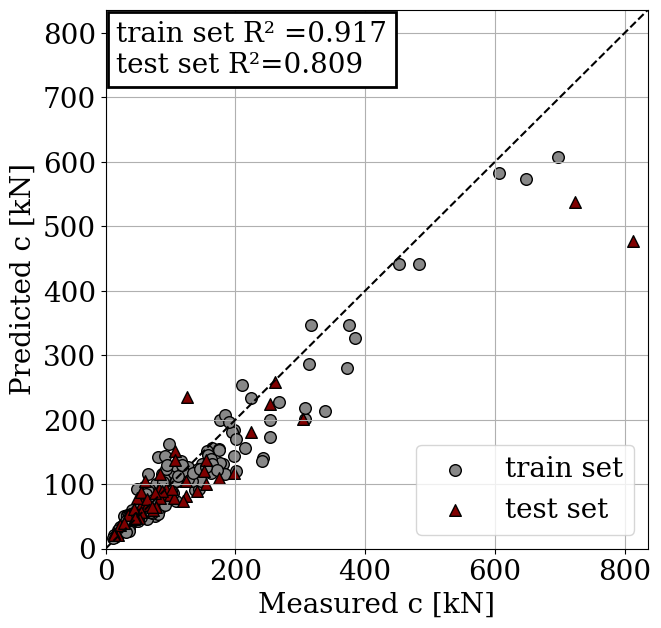

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

target_name=["a","b","c"]
guide = np.max([np.max(inverse_result1.iloc[:,2]),np.max(inverse_result1.iloc[:,3])])*1.2
# guide = np.max([np.max(inverse_result1.iloc[:,2]),np.max(asce.loc[df_index_test_best,:].iloc[:,target_num])])*1.1

line_data = [0.0, guide]
line_test = [0.0, guide]
plt.figure(figsize=(7, 7))
plt.rc('font', size=20)
plt.margins(x=0, y=0)

actual_values = inverse_result1.iloc[:,2]
predicted_values = inverse_result1.iloc[:,3]
r_squared = r2_score(actual_values, predicted_values)

actual_values_c = inverse_result2.iloc[:,2]
predicted_values_c = inverse_result2.iloc[:,3]
r_squared_c = r2_score(actual_values_c, predicted_values_c)

ax = plt.scatter(actual_values, predicted_values, color="black", s=70, edgecolor="black", facecolors="#888888")
ax.set_label('train set')
ax1 = plt.scatter(actual_values_c, predicted_values_c, color="#880000", s=70, marker="^", edgecolor="black", facecolors="#800000")
ax1.set_label('test set')

# plt.xlabel("Measured drift ratio ​[rad]​")
# plt.ylabel("Predicted drift ratio [rad]​​")
plt.xlabel("Measured c ​[kN]​")
plt.ylabel("Predicted c ​[kN]​")

plt.plot(line_data, line_data, color="black", linestyle='dashed')
plt.legend(loc="lower right")
plt.grid()
# text = f"R-squared : {r_squared:.2f}\nR-squared after: {r_squared_c:.2f}"
bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=2)
# plt.text(0.02, 0.98, f"train set R² ={r_squared:.3f}\ntest set R²={r_squared_c:.3f}",
plt.text(0.02, 0.98, f"train set R² ={r_squared:.3f}\ntest set R²={r_squared_c:.3f}",
         bbox=bbox_props, transform=plt.gca().transAxes, ha="left", va="top")
# plt.xticks(np.arange(0, guide, 0.02))
# plt.yticks(np.arange(0, guide, 0.02))
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

target_name=["a","b","c"]
guide = np.max([np.max(inverse_result1.iloc[:,2]),np.max(inverse_result1.iloc[:,3]),np.max(asce.loc[df_index_test_best,:].iloc[:,target_num])])*1.1
line_data = [0.0, guide]
line_test = [0.0, guide]
plt.figure(figsize=(7, 7))
plt.rc('font', size=20)
plt.margins(x=0, y=0)

actual_values = inverse_result1.iloc[:,2]
predicted_values = inverse_result1.iloc[:,3]
r_squared = r2_score(actual_values, predicted_values)

actual_values_c = inverse_result1.iloc[:,2]
predicted_values_c = asce.loc[df_index_train_best,:].iloc[:,target_num]
r_squared_c = r2_score(actual_values_c, predicted_values_c)

ax =  plt.scatter(actual_values, predicted_values, color="#880000", s=70, marker="^", edgecolor="black", facecolors="#800000")
ax.set_label('Proposed model')
ax1 = plt.scatter(actual_values_c, predicted_values_c, color="blue", s=70, edgecolor="blue", facecolors="#888888")
ax1.set_label('ASCE 41-17')

plt.xlabel("Measured drift ratio ​[rad]​")
plt.ylabel("Predicted drift ratio [rad]​​")
# plt.xlabel("Measured values ​[kN]​")
# plt.ylabel("Predicted values ​[kN]​")

plt.plot(line_data, line_data, color="black", linestyle='dashed')
plt.legend(loc="lower right")
plt.grid()
# text = f"R-squared : {r_squared:.2f}\nR-squared after: {r_squared_c:.2f}"
bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=2)
plt.text(0.02, 0.98, f"Proposed model R² ={r_squared:.3f}\nASCE 41-17 R²={r_squared_c:.3f}",
         bbox=bbox_props, transform=plt.gca().transAxes, ha="left", va="top")
# plt.xticks(np.arange(0, guide, 0.02))
# plt.yticks(np.arange(0, guide, 0.02))
plt.show()



## 이상치 제거

이상치 제거를 위해 필요한 변수 탐색

In [ ]:
 def gradual_backbone(target_num):
  rsod_para=pd.read_csv("rsod_parameters.csv",encoding='cp949')
  df= pd.read_csv("df_275samples_1030.csv", encoding='cp949')
  df_output=df.iloc[:, -8:]
  df_input=df.iloc[:,:-8]
  X = df_input
  y = df_output.iloc[:,target_num]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None,shuffle=True)
  model = XGBRegressor(objective='reg:squarederror',base_score=np.median(y))
  model.fit(X_train,y_train)
  ##데이터전처리##
  X_dp,y_dp=data_input(target_num)
  X_train, X_test, y_train, y_test = train_test_split(X_dp, y_dp, test_size=0.2, random_state=None,shuffle=True)
  df_index_test=sorted(X_test.index.tolist())
  df_index_train=sorted(X_train.index.tolist())
  model = XGBRegressor(objective='reg:squarederror',base_score=np.median(y_dp))
  model.fit(X_train,y_train)
  ##초기튜닝##
  model_it=initial_tunning_pso(X_train, X_test, y_train, y_test)
  X_test=X_dp.loc[df_index_test,:]
  y_test=y_dp.loc[df_index_test]
  X_train=X_dp.loc[df_index_train,:]
  y_train=y_dp.loc[df_index_train]
  #이상치제거
  X_rsod,y_rsod,real_remove_df=outlier_eliminater(X_dp,y_dp,5,rsod_para.iloc[target_num,0],rsod_para.iloc[target_num,1],rsod_para.iloc[target_num,2],model_it)
  return X_rsod,y_rsod,real_remove_df
  # X_train, X_test, y_train, y_test = train_test_split(X_rsod, y_rsod, test_size=0.2, random_state=None,shuffle=True)
  # df_index_test=sorted(X_test.index.tolist())
  # df_index_train=sorted(X_train.index.tolist())
  # model_it=initial_tunning_pso(X_train, X_test, y_train, y_test)

In [ ]:
# if target_num in(0,1,2,6):
#   list1=[0.2, 0.35, 0.5] # driftnp.mean(r2_test_result)
# elif target_num==4:
#   list1=[0.15, 0.25, 0.35] # force for ds3
# else:
#   list1=[0.2, 0.3, 0.4] # force
# list2=[6, 11,16]
# list3=[0.05,0.075,0.1]
# r2_mean_list=[]
# r2_std_list=[]
# comb = list(itertools.product(list1, list2, list3))
# for a in tqdm(range(len(comb))):
#   [var1,var2,var3]=comb[a]
#   r2_result,X_rsod,y_rsod=model_rsod(target_num,num,num2,var1,var2,var3,model)
#   r2_mean_list.append(np.mean(r2_result))
#   r2_std_list.append(np.std(r2_result))
# # 성능 지표의 조합 계산
# weights = [0.7, 0.3]  # 평균에 0.7, 표준편차에 0.3의 가중치를 줌

# combined_metric = []
# for mean, std in zip(r2_mean_list, r2_std_list):
#     combined_value = (weights[0] * mean) + (weights[1] * (1 - std))
#     combined_metric.append(combined_value)

# # 성능 지표의 조합을 기반으로 모델 순위 매기기
# ranking = np.argsort(combined_metric)[::-1] + 1
# rank = [comb[i - 1] for i in ranking]
# dis_var1=pd.DataFrame(rank[1:round(len(comb)/3)])[0]
# dis_var2=pd.DataFrame(rank[1:round(len(comb)/3)])[1]
# dis_var3=pd.DataFrame(rank[1:round(len(comb)/3)])[2]
# mode_var1 = statistics.mode(dis_var1)
# mode_var2 = statistics.mode(dis_var2)
# mode_var3 = statistics.mode(dis_var3)

# result_var=[mode_var1,mode_var2,mode_var3]


In [ ]:
  target_num=0

  rsod_para=pd.read_csv("rsod_parameters.csv",encoding='cp949')
  df= pd.read_csv("df_275samples_1030.csv", encoding='cp949')
  df_output=df.iloc[:, -8:]
  df_input=df.iloc[:,:-8]
  X = df_input
  y = df_output.iloc[:,target_num]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None,shuffle=True)
  model = XGBRegressor(objective='reg:squarederror',base_score=np.median(y))
  model.fit(X_train,y_train)
  ##데이터전처리##
  X_dp,y_dp=data_input(target_num)
  X_train, X_test, y_train, y_test = train_test_split(X_dp, y_dp, test_size=0.2, random_state=None,shuffle=True)
  df_index_test=sorted(X_test.index.tolist())
  df_index_train=sorted(X_train.index.tolist())
  model = XGBRegressor(objective='reg:squarederror',base_score=np.median(y_dp))
  model.fit(X_train,y_train)
  ##초기튜닝##
  model_it=initial_tunning_pso(X_train, X_test, y_train, y_test)
  X_test=X_dp.loc[df_index_test,:]
  y_test=y_dp.loc[df_index_test]
  X_train=X_dp.loc[df_index_train,:]
  y_train=y_dp.loc[df_index_train]

In [ ]:
rsod_para=pd.read_csv("rsod_parameters.csv",encoding='cp949')
for target_num in tqdm(range(2)):
    X_dp,y_dp=data_input1(target_num)
    X_train, X_test, y_train, y_test = train_test_split(X_dp, y_dp, test_size=0.2, random_state=None,shuffle=True)
    df_index_test=sorted(X_test.index.tolist())
    df_index_train=sorted(X_train.index.tolist())
    model = XGBRegressor(objective='reg:squarederror',base_score=np.median(y_dp))
    model.fit(X_train,y_train)
    ##초기튜닝##
    model_it=initial_tunning_pso(X_train, X_test, y_train, y_test)
    X_test=X_dp.loc[df_index_test,:]
    y_test=y_dp.loc[df_index_test]
    X_train=X_dp.loc[df_index_train,:]
    y_train=y_dp.loc[df_index_train]

    var1=rsod_para.iloc[target_num,0]
    var2=rsod_para.iloc[target_num,1]
    var3=rsod_para.iloc[target_num,2]
    threshold = (y.mean() * var1) ** 2
    X_rsod=X_dp
    y_rsod=y_dp
    num=50
    remove_ind=[]
    remove_df = pd.DataFrame(index=range(round(0.2*len(y_rsod))), columns=range(num))
    for iii in range (num): # outlier list 만들어 낼 case 개수
      remove_list=[]
      while len(remove_list)<var2: # 빈도 파악할 outlier 개수
        min_score = 1000
        base_score_value=np.median(y_rsod)
        for i in range(1): # removing set의 필터링
          df_index_train,df_index_test=train_test_index2(X_rsod,y_rsod)
          X_train=X_rsod.loc[df_index_train]
          y_train=y_rsod.loc[df_index_train]
          X_test=X_rsod.loc[df_index_test]
          y_test=y_rsod.loc[df_index_test]
          model.fit(X_train, y_train)
          preds = model.predict(X_test)

          score = mean_squared_error(y_test, preds)**0.5
          if score < min_score:
            remove_train = X_test
            remove_test = preds
            min_score = score

        pred_value = remove_test.tolist()
        remove_set = remove_train.reset_index()["index"].to_list()
        real_value = []

        for ii in remove_set:
          real_value.append(y[ii])

        count = 0
        for p, r in zip(pred_value, real_value):
          temp = (p - r) ** 2
          if temp > threshold:
            remove_ind.append(remove_set[count])
          count += 1

        remove_list.extend(remove_ind)
        remove_ind=[]
        for a in range  (len(remove_list)):
          remove_df[iii][a]=remove_list[a]

    tmp=remove_df.values.flatten().tolist()
    ttmp=[x for x in tmp if not pd.isna(x)]
    counts = Counter(ttmp)
    counts_df = pd.DataFrame(list(counts.items()), columns=['Value', 'Count'])
    count_df = counts_df.sort_values(by='Count', ascending=False)
    count_df.to_csv(f'outlier_target{target_num}.csv')

100%|██████████| 2/2 [00:39<00:00, 19.99s/it]


In [ ]:
counts_df = pd.DataFrame(list(counts.items()), columns=['Value', 'Count'])
count_df = counts_df.sort_values(by='Count', ascending=False)
count_df.to_csv(f'outlier_target{target_num}.csv')

In [ ]:
pd.DataFrame[]

In [ ]:
counts_df.to_csv(f'outlier_target{target_num}.csv')
  # plt.savefig(f'plot_{column}.png')

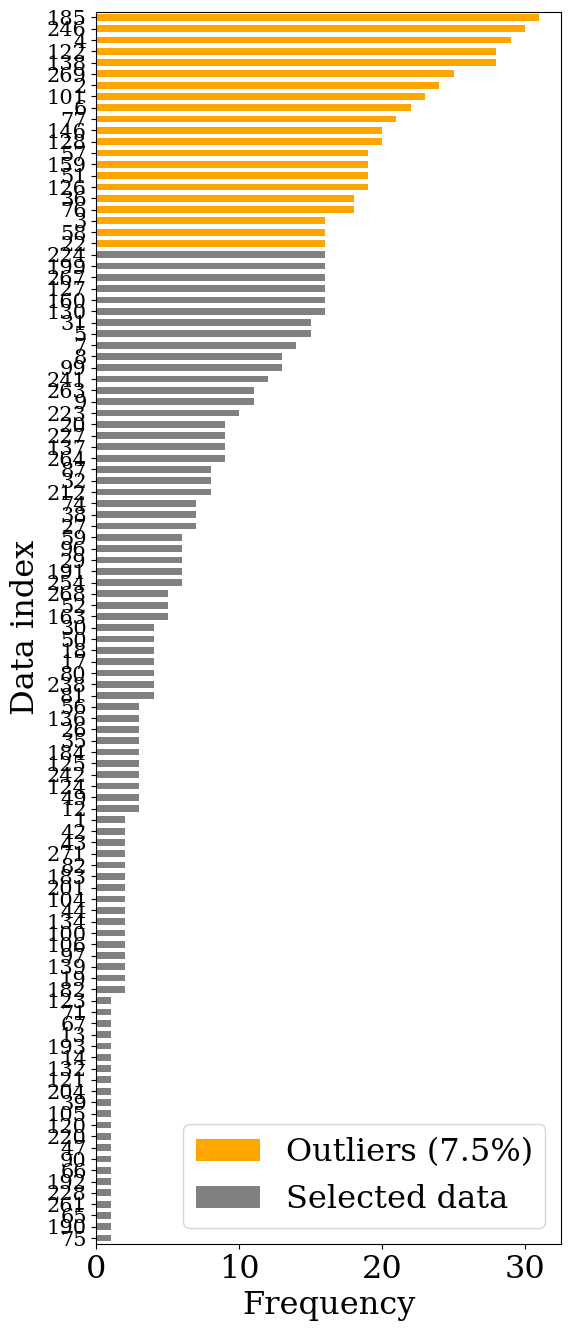

In [ ]:

# 전체 막대 그래프의 개수
total_bars = len(count_df)
top_bars = total_bars-round(var3*len(y))
# 막대 그래프 색상 설정
colors = ['grey' if i < top_bars else 'orange' for i in range(total_bars)]
# 막대 그래프 그리기
plt.figure(figsize=(6,16))
plt.barh(range(total_bars), count_df['Count'], color=colors, height=0.6)
plt.rc('font', size=23)
# 레이블 및 제목 추가
plt.xlabel('Frequency',fontsize=23)
plt.ylabel('Data index',fontsize=23)
plt.ylim(-0.5, total_bars - 0.5)
plt.yticks(range(total_bars), count_df['Value']+1, fontsize=15)
# Create custom legend entries
legend_handles = [
    plt.Rectangle((0, 0), 1, 1, fc='orange'),
    plt.Rectangle((0, 0), 1, 1, fc='gray')
]

plt.legend(legend_handles, ["Outliers (7.5%)","Selected data"],loc='lower right')

# 그래프 표시
plt.show()

이상치 제거 수행 및 수행 후 성능 평가 (평균 0.7 이상, 표준편차 0.1이하 시 합격)

In [ ]:
r2_7,X_rsod,y_rsod=model_rsod(target_num,num,num2*5,mode_var1,mode_var2,mode_var3,model)
# r2_7,X_rsod,y_rsod=model_rsod(target_num,num,num2*5,0.5,11,0.1,model)
print(np.mean(r2_7))
print(np.std(r2_7))

## 차원 축소

### 그림그리기

In [ ]:
num=100
ranking_df = pd.DataFrame(index=range(X_rsod.shape[1]), columns=range(num))
importance_df = pd.DataFrame(index=range(X_rsod.shape[1]), columns=range(num))
base_score_value=np.mean(y_rsod)
df_index_train,df_index_test=train_test_index(X_rsod,y_rsod,num)
for i in range(num):
  X_train=X_rsod.loc[df_index_train[i]]
  y_train=y_rsod.loc[df_index_train[i]]
  X_test=X_rsod.loc[df_index_test[i]]
  y_test=y_rsod.loc[df_index_test[i]]
  model_fs1 = model
  model_fs1.fit(X_train, y_train)
  importances = model_fs1.feature_importances_
  importance_df[i]=importances

  # Print the feature importances in descending order
  indices = importances.argsort()[::-1]
  ranking_df[i]=indices

importance_df.mean(axis=1)
iqr_low=[]
for low in range(len(importance_df)):
    q1 = importance_df.iloc[low,:].quantile(0.25)
    q3 = importance_df.iloc[low,:].quantile(0.75)

    # IQR 계산
    iqr = q3 - q1
    iqr_low.append(iqr)
x_tmp=importance_df.mean(axis=1)
y_tmp=iqr_low
x1=np.median(x_tmp)
y1=np.median(y_tmp)

importance_df.mean(axis=1)
iqr_low=[]
for low in range(len(importance_df)):
    q1 = importance_df.iloc[low,:].quantile(0.25)
    q3 = importance_df.iloc[low,:].quantile(0.75)

    # IQR 계산
    iqr = q3 - q1
    iqr_low.append(iqr)
x_tmp=importance_df.mean(axis=1)
y_tmp=iqr_low
x1=np.median(x_tmp)
y1=np.median(y_tmp)
indices = np.where((x_tmp<x1) & (iqr_low<y1))
columns_to_delete = indices[0]
X_fs1 = X_rsod.drop(X_rsod.columns[columns_to_delete], axis=1)

In [ ]:
# 좌표평면 그래프 그리기
plt.figure(figsize=(6,9))  # 그래프의 크기 설정 (선택 사항)
plt.rc('font', size=15)
# 좌표평면에 점 찍기
plt.scatter(x_tmp, y_tmp, color="grey",edgecolor="black",alpha=0.7,s=60)
plt.axvline(x=x1, color='black', linestyle='--')
plt.axhline(y=y1, color='black', linestyle='--')
# 직사각형 그리기
rectangle = patches.Rectangle((0,0), x1,y1, linewidth=1, edgecolor='r', facecolor='r', alpha=0.5)
plt.gca().add_patch(rectangle)
# 그래프에 제목과 축 레이블 추가 (선택 사항)

plt.xlabel("Median of feature importance")
plt.ylabel("IQR length of feature importance ")

# Create custom legend entries
legend_handles = [
    plt.Rectangle((0, 0), 1, 1, fc='red',alpha=0.5),
    plt.Line2D([0], [0], color='black', linestyle='--')
]

plt.legend(legend_handles, ["Low importance area","Median line"])
# plt.xlim(0,0.2)
# plt.ylim(0,0.15)
# 그래프 보기
plt.show()

In [ ]:
# 그래프 그리기
plt.figure(figsize=(6,9))
plt.rc('font', size=15)
important_features=importance_df.T.iloc[:,indices[0]]
low_important_features=importance_df.T.iloc[:,X_fs1.columns]
# 중요한 feature 그룹의 Box Plot 그리기 (투명하지 않음)
bp_important = plt.boxplot(important_features, vert=False, patch_artist=True, positions=indices[0]+1)
for patch in bp_important['boxes']:
    patch.set_facecolor('red')
    patch.set_alpha(0.5)
# 중요하지 않은 feature 그룹의 Box Plot 그리기 (반투명)
bp_low_important = plt.boxplot(low_important_features, vert=False, patch_artist=True, positions=X_fs1.columns+1)
for patch in bp_low_important['boxes']:
    patch.set_facecolor('lightgray')
    patch.set_alpha(0.5)  # 반투명 설정

# 레이블 및 제목 추가
plt.xlabel('Feature Importance from one hundred runs')
# plt.yticks(np.arange(1, num_samples + 1))
plt.ylabel('Feature Index')
# 중요한 feature과 중요하지 않은 feature에 대한 레전드 생성
important_legend = mpatches.Patch(facecolor='red', edgecolor='black', alpha=0.5, label='Minor features')
low_important_legend = mpatches.Patch(facecolor='lightgray', edgecolor='black', alpha=0.5, label='Remaining features')
# 레전드 추가
# plt.legend(handles=[important_legend, low_important_legend], loc='upper right')
plt.legend(handles=[important_legend, low_important_legend], loc='lower right')
# 그래프 표시
# plt.xlim(0,0.3)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# 변수 중요도 및 변수 이름 가져오기 (예: feature_names는 입력 변수의 이름 목록)
importances = model_fs1.feature_importances_
index_array=list(range(1, 23))
index_str = pd.Index(index_array)
feature_names =index_str
# 중요도와 변수 이름을 연결
feature_importance = list(zip(feature_names, importances))
# 중요도를 내림차순으로 정렬
feature_importance.sort(key=lambda x: x[1], reverse=False)

plt.figure(figsize=(3.7, 7))
plt.rc('font', size=15)
plt.barh(top_features, top_importances, color='grey', height=0.6)
# plt.barh(top_features, top_importances, color='#FF8C00')
plt.xlabel('Feature Importance \nfrom a single run')
plt.ylabel('Feature index')
plt.yticks(range(1, 23))

plt.ylim(0.5,22.5)
plt.gca().invert_xaxis()

In [ ]:
import matplotlib.pyplot as plt

# 변수 중요도 및 변수 이름 가져오기 (예: feature_names는 입력 변수의 이름 목록)
importances = model_fs1.feature_importances_
index_array = list(range(1, 23))
index_str = pd.Index(index_array)
feature_names = index_str
# 중요도와 변수 이름을 연결
feature_importance = list(zip(feature_names, importances))
# 중요도를 내림차순으로 정렬
feature_importance.sort(key=lambda x: x[1], reverse=False)

plt.figure(figsize=(10, 5))
plt.rc('font', size=15)

# 가로 막대 그래프 그리기
plt.bar(feature_names, importances, color='grey', width=0.6)
# plt.bar(feature_names, importances, color='#FF8C00')
plt.ylabel('Feature Importance from a single run')
plt.xlabel('Feature index')
# plt.yticks(range(1, 23))
plt.xticks(range(1, 23),rotation=0)  # x 축 레이블의 회전 각도
plt.xlim(0.5, 22.5)

# 그래프 표시
plt.show()


### 실행

In [ ]:
X_fs1,y_fs1,model_fs1 =fs1(X_rsod,y_rsod,num2*5,model) # feature 줄이기

## 모든 파라메터(10개) 튜닝

tuning 할 최적의 dataset 찾기

In [ ]:
X_train,y_train,X_test,y_test,df_index_test=tuning_dataset(X_fs1,y_fs1,num,model_fs1)

boosting parameter 튜닝

In [ ]:
# model_hype_result = tuning(X_train,y_train,X_test,y_test,model_fs1)
model=tunning_pso(X_train,y_train,X_test,y_test)

# 성능평가

## 정확도 측정

test set 100회 중 1등 뽑기

In [ ]:
X_train,y_train,X_test,y_test,df_index_train,df_index_test,max_r2,r2_test_hype_result=model_eval_100(X_fs1,y_fs1,model)

교차검증 10회 중 1등 뽑기 (0.7이상 합격)

In [ ]:
max_r2=np.max(r2_test_hype_result)
cv_results_r2_hype=cv_model_eval(model,X_fs1,y_fs1) # 교차검증 결과값
print(np.max(r2_test_hype_result))
print(np.max(cv_results_r2_hype))

0.8395534404621295
0.7203771670018368


## 결과 뽑기

예측값, 실제값 비교 (train, test set)

In [ ]:
result_df1,result_df2=result(X_train,y_train,X_test,y_test,df_index_train,df_index_test,model) # 예측값

# trian set : result_df1
# test set  : result_df2
inverse_result1=inverse_transe(result_df1,target_num)
inverse_result2=inverse_transe(result_df2,target_num) # 예측값 역변환

예측값, 실제값 역변환 (train, test set)

In [ ]:
inverse_result1=inverse_transe(result_df1,target_num)
inverse_result2=inverse_transe(result_df2,target_num) # 예측값 역변환

# target별 예측 대 실제 비교 그림 그리기

## train set

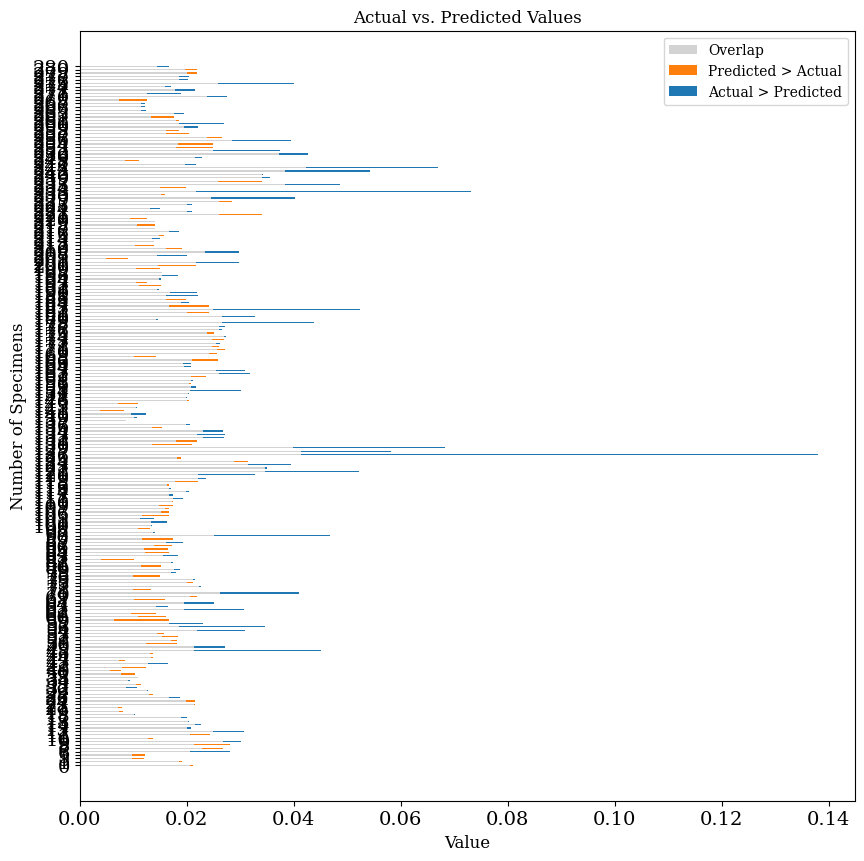

In [ ]:
# Create a list of subject names
subjects = list(inverse_result1.index)
predicted=inverse_result1.iloc[:,3]
actual=inverse_result1.iloc[:,2]
# Set the width of the bars
bar_width = 0.35

# Set the position of the bars on the x-axis
r1 = np.arange(len(subjects))

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10,10))
plt.rc('font', size=10)

# Create bars for the overlapping part in gray color
ax.barh(r1, np.minimum(predicted, actual), height=bar_width, color='lightgray', label='Overlap')
# Create bars for the predicted values larger than actual values in orange color
ax.barh(r1, np.maximum(predicted - actual, 0), height=bar_width, left=np.minimum(predicted, actual), color='tab:orange', label='Predicted > Actual')
# Create bars for the actual values larger than predicted values in blue color
ax.barh(r1, np.maximum(actual - predicted, 0), height=bar_width, left=np.minimum(predicted, actual), color='tab:blue', label='Actual > Predicted')

# Add labels, titles, and legends
ax.set_xlabel('Value', fontsize=12)
ax.set_ylabel('Number of Specimens',fontsize=12)
ax.set_title('Actual vs. Predicted Values',fontsize=12)
ax.set_yticks(r1)
ax.set_yticklabels(subjects)
ax.legend()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


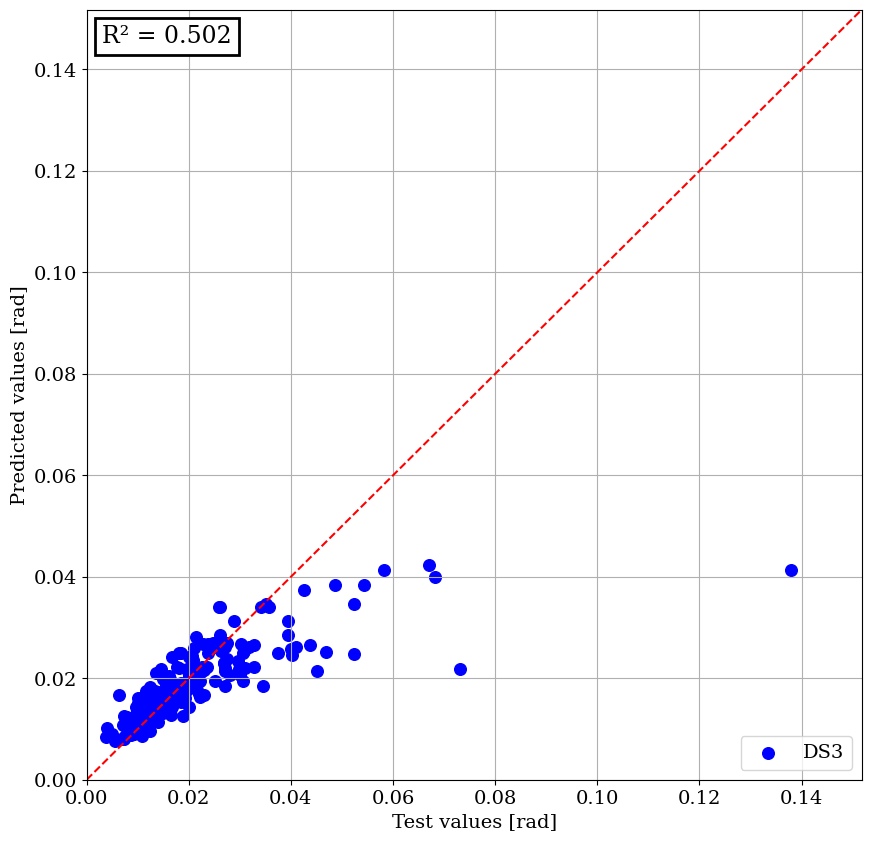

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

target_name=["DS1", "DS2","DS3","DS4", "Vy","Vu","DS4/DS2"]
guide = np.max(np.max(inverse_result1.iloc[:,2:4]))*1.1
line_data = [0.0, guide]
line_test = [0.0, guide * 0.75]
plt.figure(figsize=(10, 10))
plt.rc('font', size=14)
plt.margins(x=0, y=0)

actual_values = inverse_result1.iloc[:,2]
predicted_values = inverse_result1.iloc[:,3]
r_squared = r2_score(actual_values, predicted_values)

ax = plt.scatter(actual_values, predicted_values, color="blue", s=70)
ax.set_label(target_name[target_num])
plt.xlabel("Test values ​​[rad]")
plt.ylabel("Predicted values ​​[rad]")

plt.plot(line_data, line_data, color="red", linestyle='dashed')
plt.legend(loc="lower right")
plt.grid()

bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=2)
plt.text(0.02, 0.98, f"R² = {r_squared:.3f}", fontsize=17,
         bbox=bbox_props, transform=plt.gca().transAxes, ha="left", va="top")

plt.show()


## test set

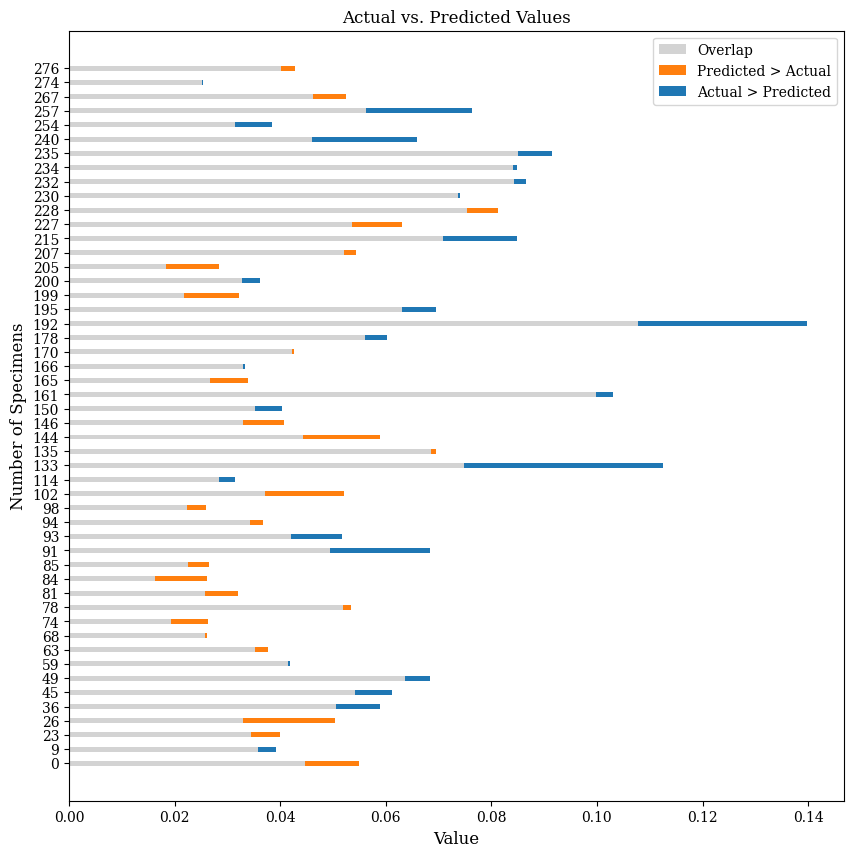

In [ ]:
# Create a list of subject names
subjects = list(inverse_result2.index)
predicted=inverse_result2.iloc[:,3]
actual=inverse_result2.iloc[:,2]
# Set the width of the bars
bar_width = 0.35

# Set the position of the bars on the x-axis
r1 = np.arange(len(subjects))

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10,10))
plt.rc('font', size=10)

# Create bars for the overlapping part in gray color
ax.barh(r1, np.minimum(predicted, actual), height=bar_width, color='lightgray', label='Overlap')
# Create bars for the predicted values larger than actual values in orange color
ax.barh(r1, np.maximum(predicted - actual, 0), height=bar_width, left=np.minimum(predicted, actual), color='tab:orange', label='Predicted > Actual')
# Create bars for the actual values larger than predicted values in blue color
ax.barh(r1, np.maximum(actual - predicted, 0), height=bar_width, left=np.minimum(predicted, actual), color='tab:blue', label='Actual > Predicted')

# Add labels, titles, and legends
ax.set_xlabel('Value', fontsize=12)
ax.set_ylabel('Number of Specimens',fontsize=12)
ax.set_title('Actual vs. Predicted Values',fontsize=12)
ax.set_yticks(r1)
ax.set_yticklabels(subjects)
ax.legend()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


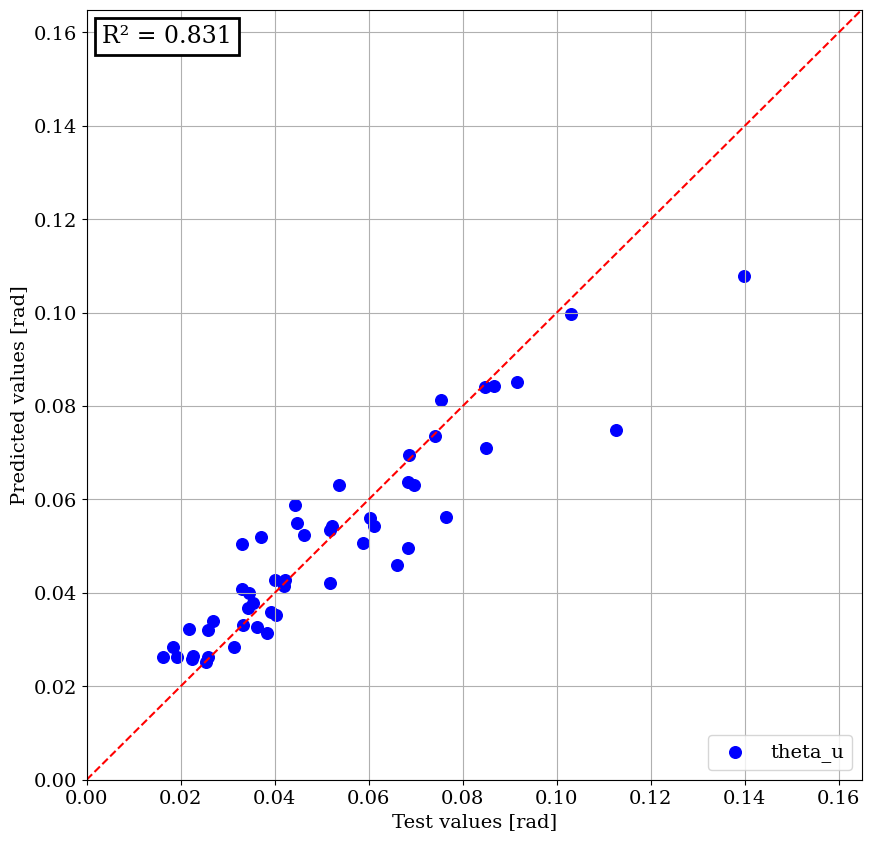

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

target_name=["theta_y","theta_c","theta_u","V_y","V_c","V_u","theta_E","V_E"]
guide = np.max(np.max(inverse_result1.iloc[:,2:4]))*1.1
line_data = [0.0, guide]
line_test = [0.0, guide * 0.75]
plt.figure(figsize=(10, 10))
plt.rc('font', size=14)
plt.margins(x=0, y=0)

actual_values = inverse_result2.iloc[:,2]
predicted_values = inverse_result2.iloc[:,3]
r_squared = r2_score(actual_values, predicted_values)

ax = plt.scatter(actual_values, predicted_values, color="blue", s=70)
ax.set_label(target_name[target_num])
plt.xlabel("Test values ​​[rad]")
plt.ylabel("Predicted values ​​[rad]")

plt.plot(line_data, line_data, color="red", linestyle='dashed')
plt.legend(loc="lower right")
plt.grid()

bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=2)
plt.text(0.02, 0.98, f"R² = {r_squared:.3f}", fontsize=17,
         bbox=bbox_props, transform=plt.gca().transAxes, ha="left", va="top")

plt.show()
